In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer
from imblearn.over_sampling import SMOTENC, SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import precision_score, make_scorer
from sklearn.base import clone
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

import warnings

warnings.filterwarnings("ignore")  # Suppress all warnings 

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
bank_marketing = fetch_ucirepo(id=222) 
  
# data (as pandas dataframes) 
X = bank_marketing.data.features 
y = bank_marketing.data.targets 
  
# metadata 
# print(bank_marketing.metadata) 
  
# variable information 
# print(bank_marketing.variables) 

In [3]:
X.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married        NaN      no     1506     yes   no   
4   33           NaN   single        NaN      no        1      no   no   

  contact  day_of_week month  duration  campaign  pdays  previous poutcome  
0     NaN            5   may       261         1     -1         0      NaN  
1     NaN            5   may       151         1     -1         0      NaN  
2     NaN            5   may        76         1     -1         0      NaN  
3     NaN            5   may        92         1     -1         0      NaN  
4     NaN            5   may       198         1     -1         0      NaN

In [4]:
X.shape

(45211, 16)

This is a fairly large dataset with both numerical and categorical features

In [5]:
y.value_counts(normalize=True)

y  
no     0.883015
yes    0.116985
Name: proportion, dtype: float64

Target variable is categorical!

This is an imbalanced dataset with only 11% being yes. Need to consider this imbalace when modeling

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
dtypes: int64(7), object(9)
memory usage: 5.5+ MB


In [7]:
X.describe()

age        balance   day_of_week      duration      campaign  \
count  45211.000000   45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210    1362.272058     15.806419    258.163080      2.763841   
std       10.618762    3044.765829      8.322476    257.527812      3.098021   
min       18.000000   -8019.000000      1.000000      0.000000      1.000000   
25%       33.000000      72.000000      8.000000    103.000000      1.000000   
50%       39.000000     448.000000     16.000000    180.000000      2.000000   
75%       48.000000    1428.000000     21.000000    319.000000      3.000000   
max       95.000000  102127.000000     31.000000   4918.000000     63.000000   

              pdays      previous  
count  45211.000000  45211.000000  
mean      40.197828      0.580323  
std      100.128746      2.303441  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%       -1.000000      0.000000  
max      871.000000    275.000000

In [8]:
#understand content of X
data_zip = zip(X.columns, X.dtypes, X.isnull().sum(), X.nunique(), np.round((X.isnull().sum()/X.shape[0])*100,2))
data_df = pd.DataFrame(data_zip, columns=['Column Name', 'Type', 'Null Count', 'Unique Count', 'Null %'])
data_df.set_index('Column Name', inplace = True)
data_df

Type  Null Count  Unique Count  Null %
Column Name                                          
age           int64           0            77    0.00
job          object         288            11    0.64
marital      object           0             3    0.00
education    object        1857             3    4.11
default      object           0             2    0.00
balance       int64           0          7168    0.00
housing      object           0             2    0.00
loan         object           0             2    0.00
contact      object       13020             2   28.80
day_of_week   int64           0            31    0.00
month        object           0            12    0.00
duration      int64           0          1573    0.00
campaign      int64           0            48    0.00
pdays         int64           0           559    0.00
previous      int64           0            41    0.00
poutcome     object       36959             3   81.75

Lets find relationships between the categorical fields

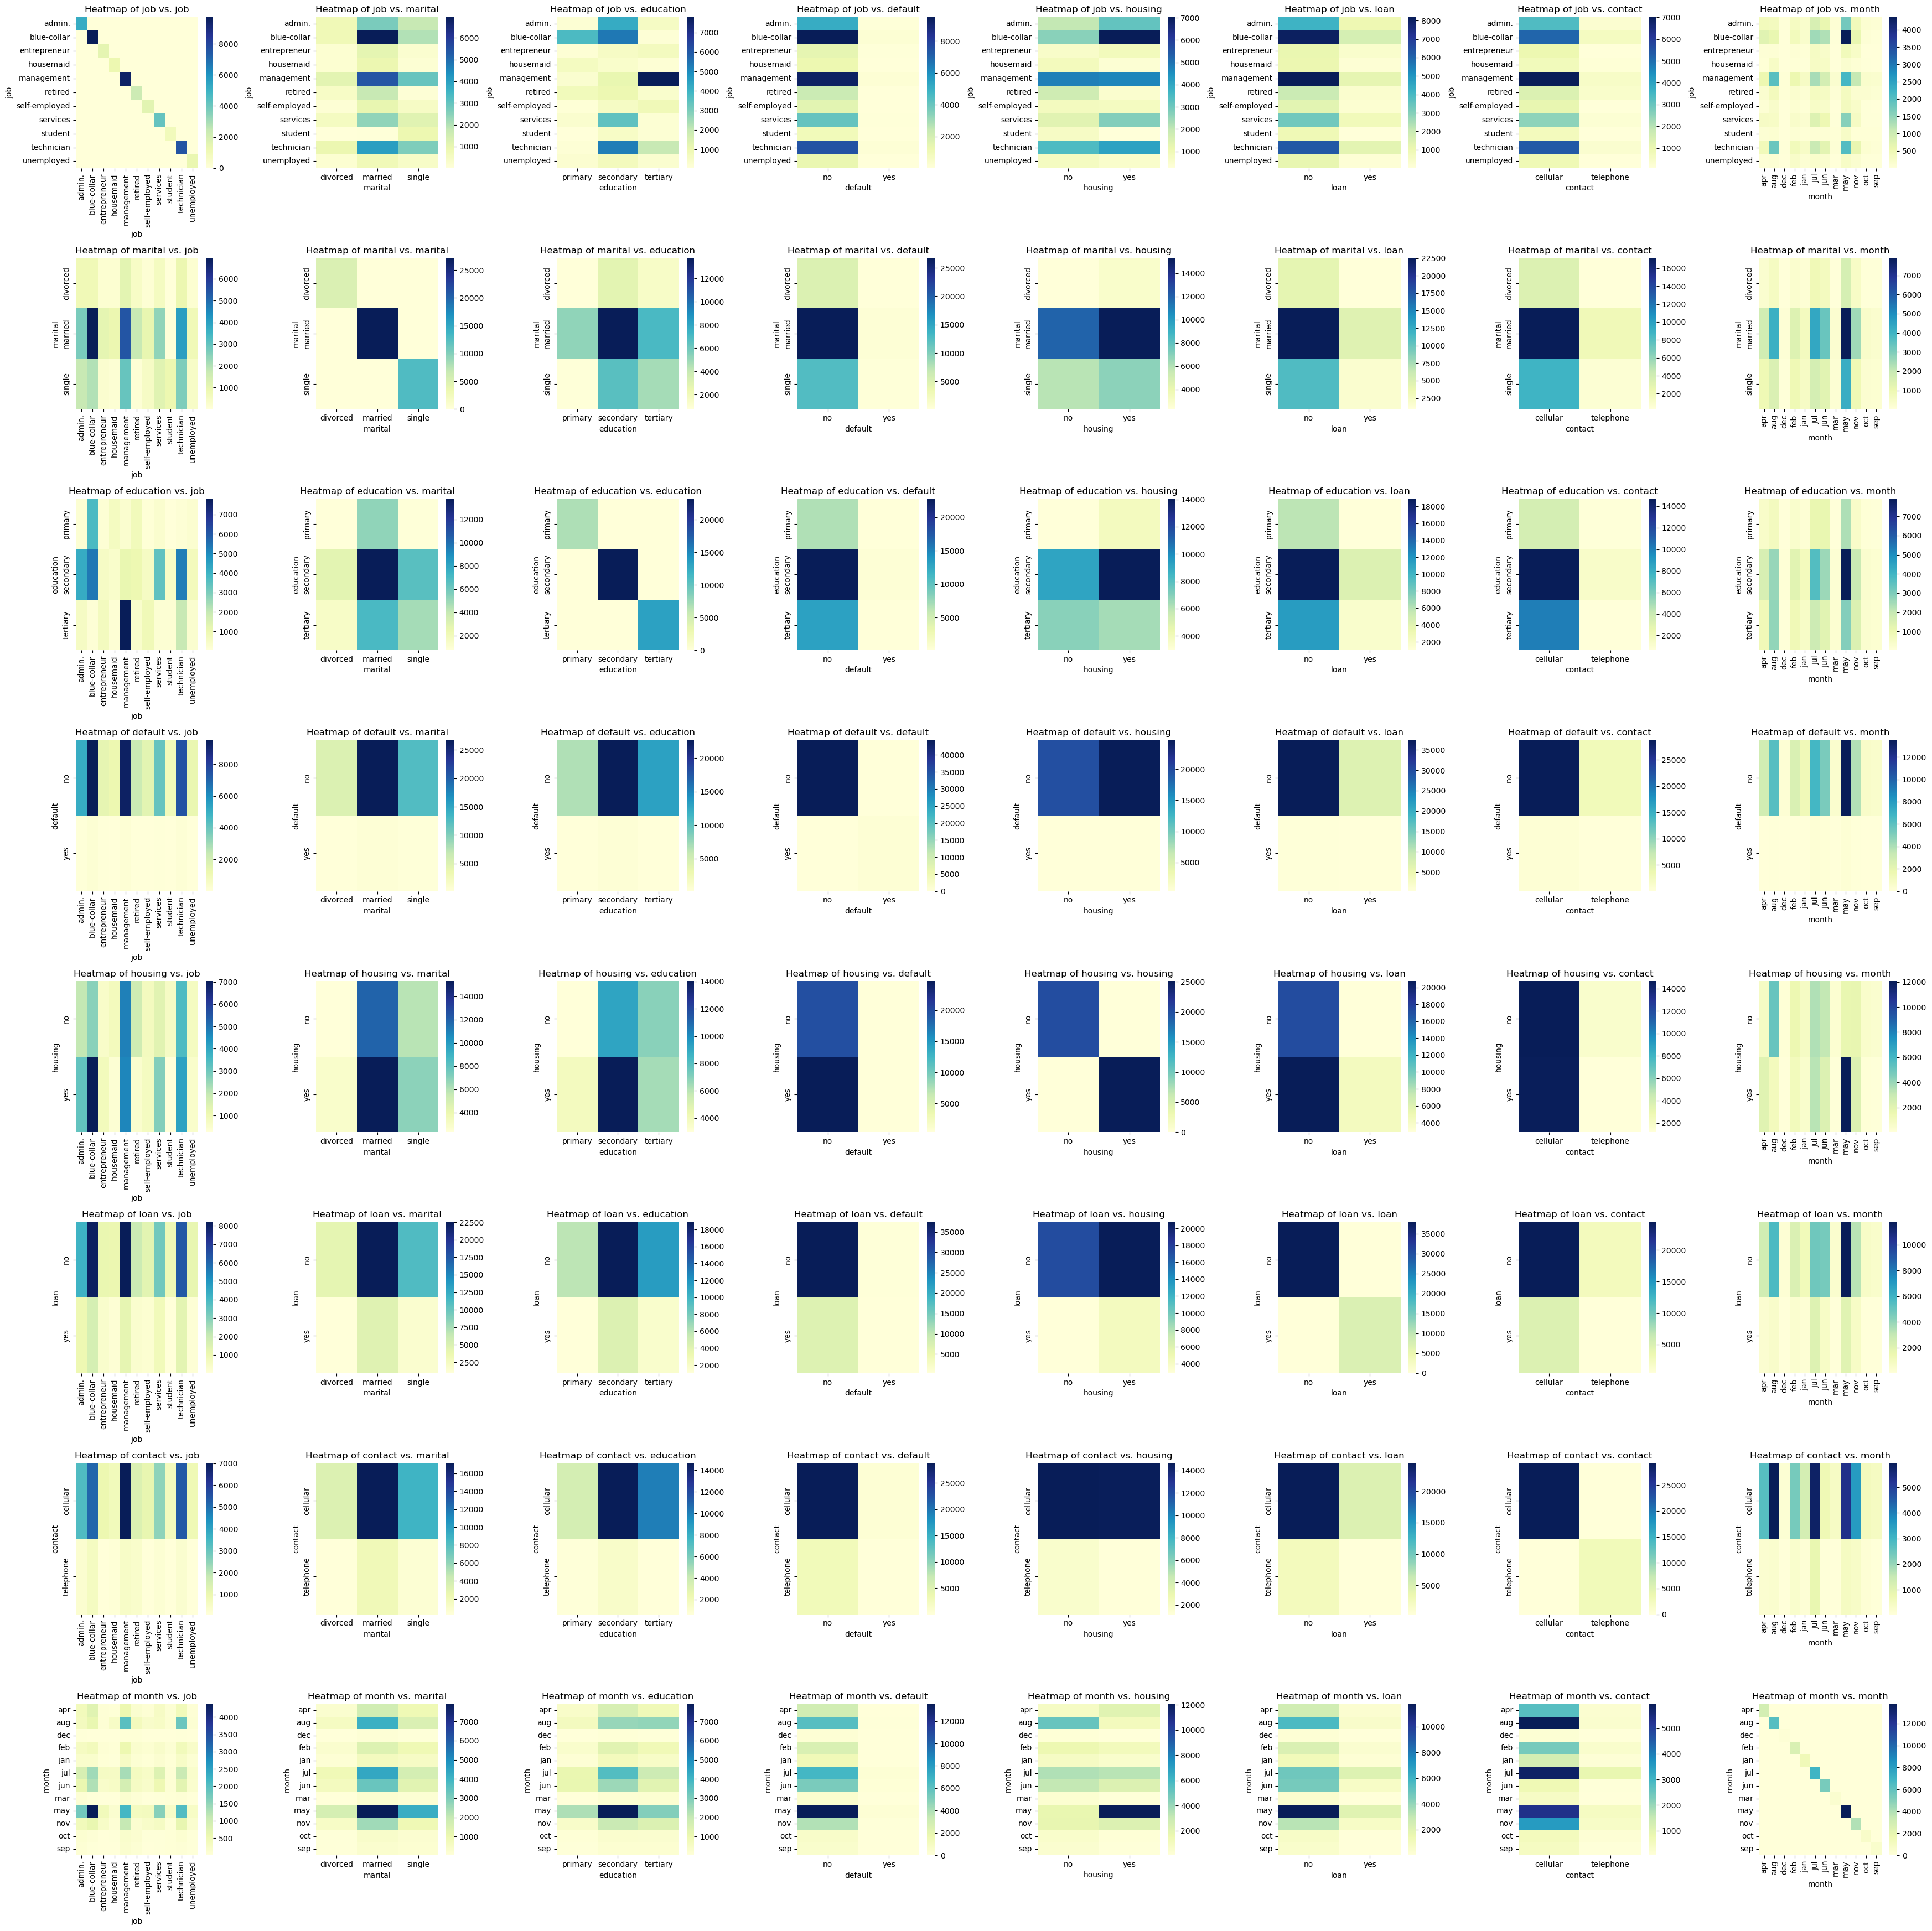

In [282]:
categorical_cols = X.select_dtypes(include=['object']).columns

fig, axes = plt.subplots(nrows=len(categorical_cols) - 1, 
                         ncols=len(categorical_cols) - 1, 
                         figsize=(35, 35))

for i, col1 in enumerate(categorical_cols[:-1]):
    for j, col2 in enumerate(categorical_cols[:-1]):
        cross_tab = pd.crosstab(X[col1], X[col2])
        sns.heatmap(cross_tab, annot=False, cmap='YlGnBu', ax=axes[i, j])
        axes[i, j].set_title(f"Heatmap of {col1} vs. {col2}")

# Adjust layout
plt.tight_layout()
plt.savefig('PA3\\final\\cetegorical_relationships.png', dpi=300, bbox_inches='tight')
plt.show()

Now, lets check if there are any direct relationships between categorical columns and y

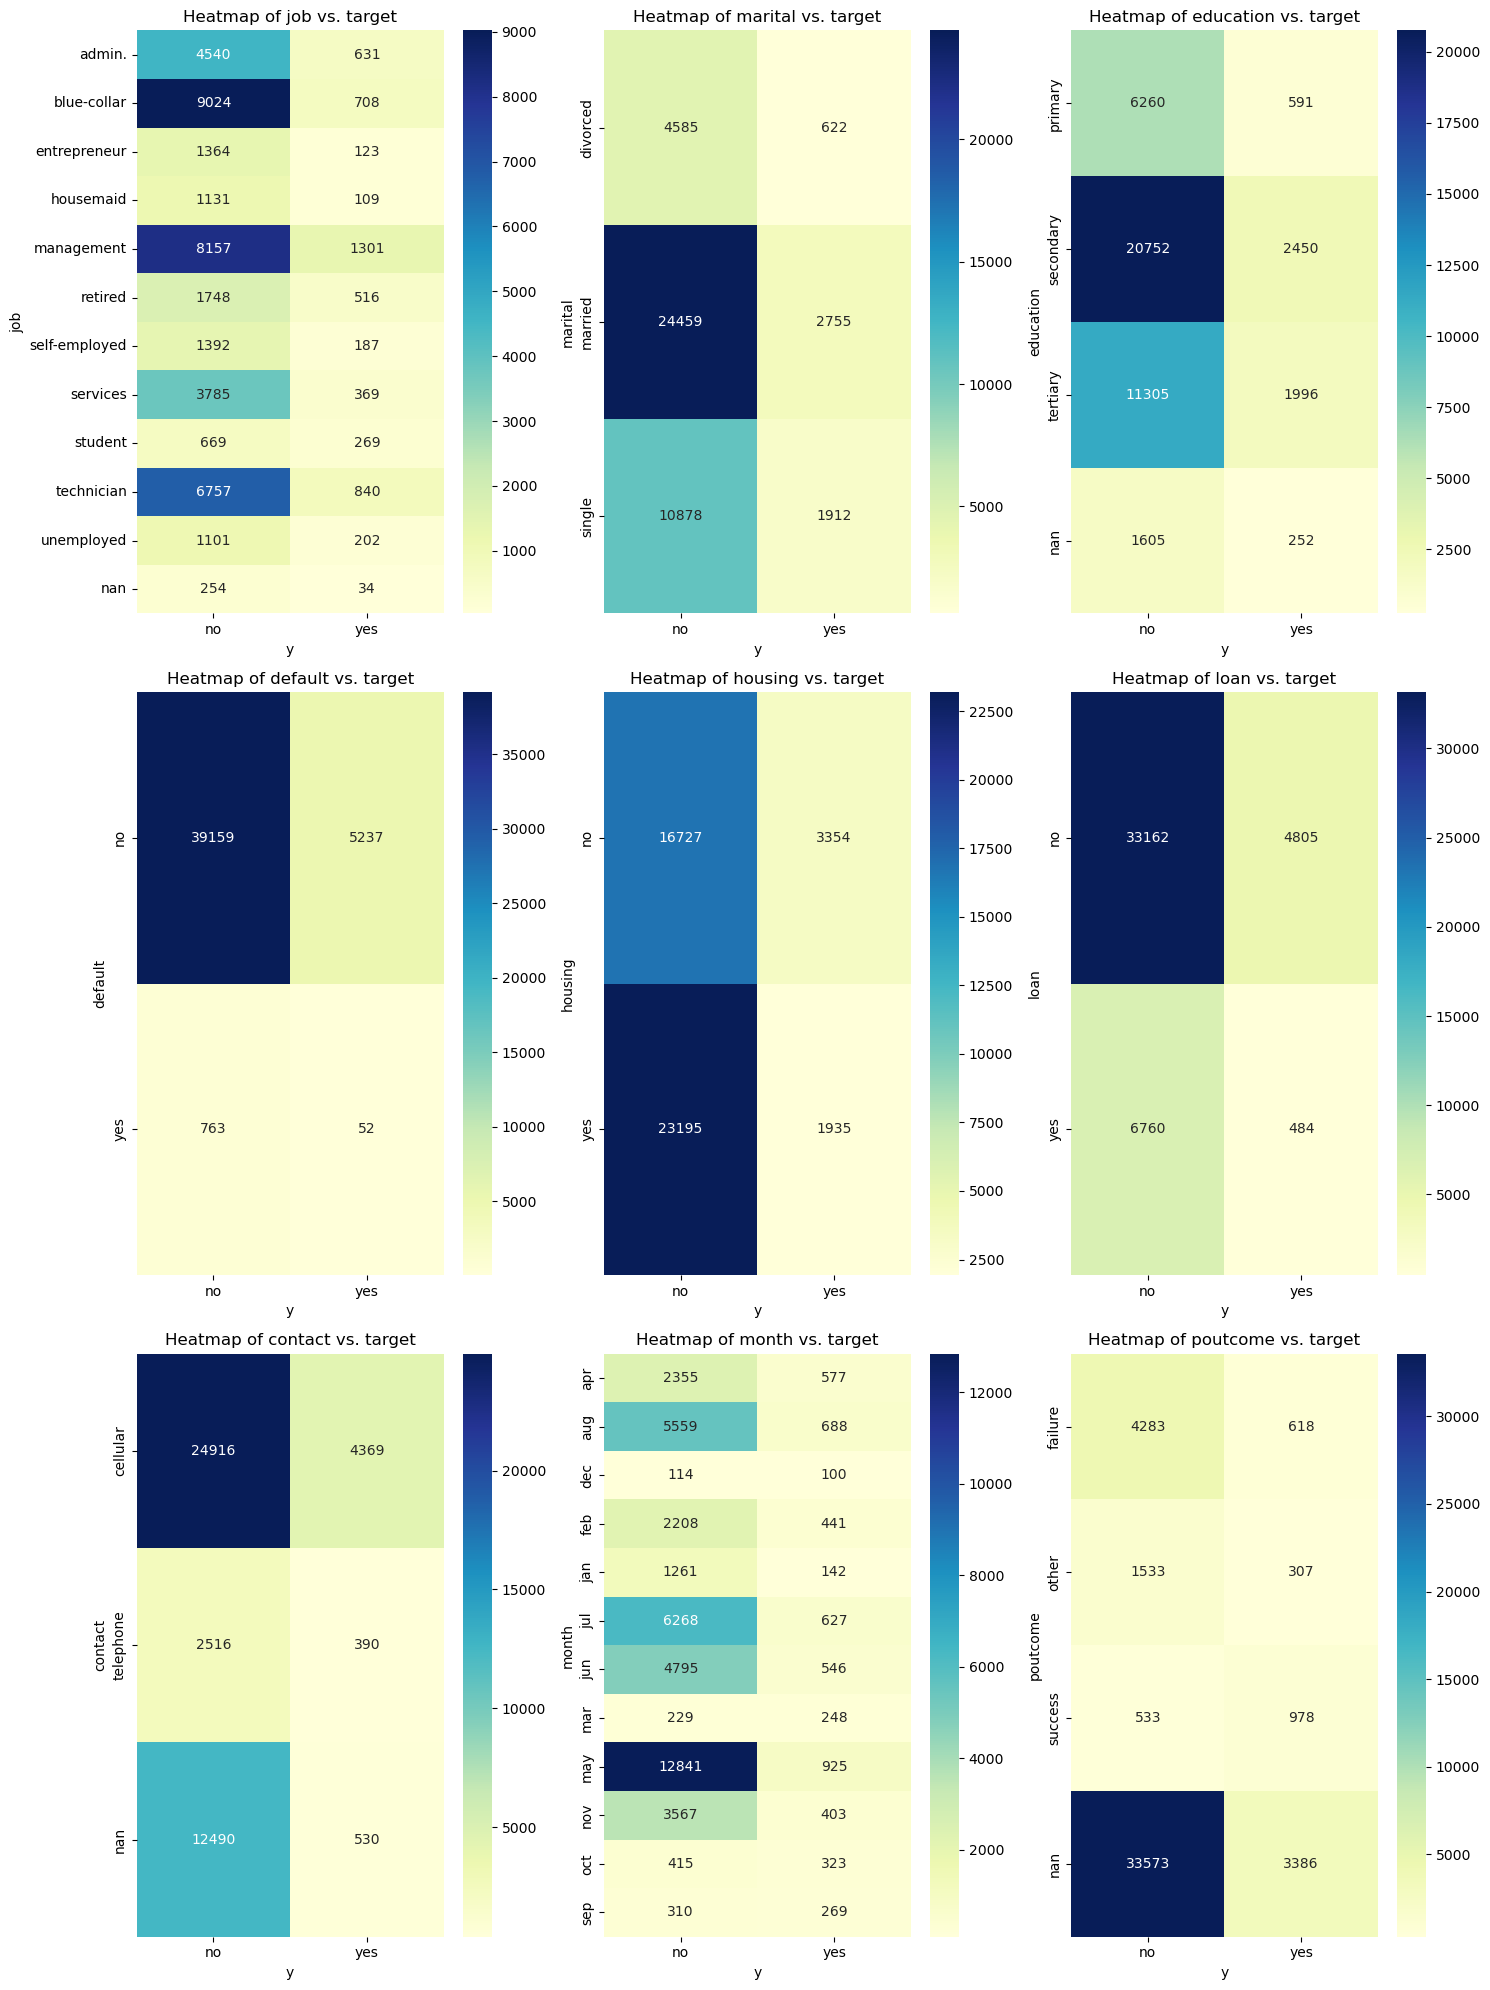

In [283]:
#What is the relationship between categorical features and y
df = pd.concat([X, y], axis=1)  
# Create a figure and axes with enough subplots for each feature
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 20))  # Adjust figsize as needed

# Flatten the axes array for easier iteration
axes = axes.flatten()
# Only consdier the categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Loop through each feature and create a heatmap
for i, feature in enumerate(categorical_cols):
    
    # Create a cross-tabulation between the feature and the target variable
    cross_tab = pd.crosstab(df[feature], df['y'], dropna=False)

    # Create a heatmap on the corresponding subplot
    sns.heatmap(cross_tab, annot=True, cmap='YlGnBu', ax=axes[i], fmt = 'd')
    axes[i].set_title(f"Heatmap of {feature} vs. target")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.savefig('PA3\\final\\categorical_features_to_y.png', dpi=300, bbox_inches='tight')
plt.show()

job, education, poutcome and contact features have to be evalauted further

Lets now Check relationship between the numerical features by through pairplots

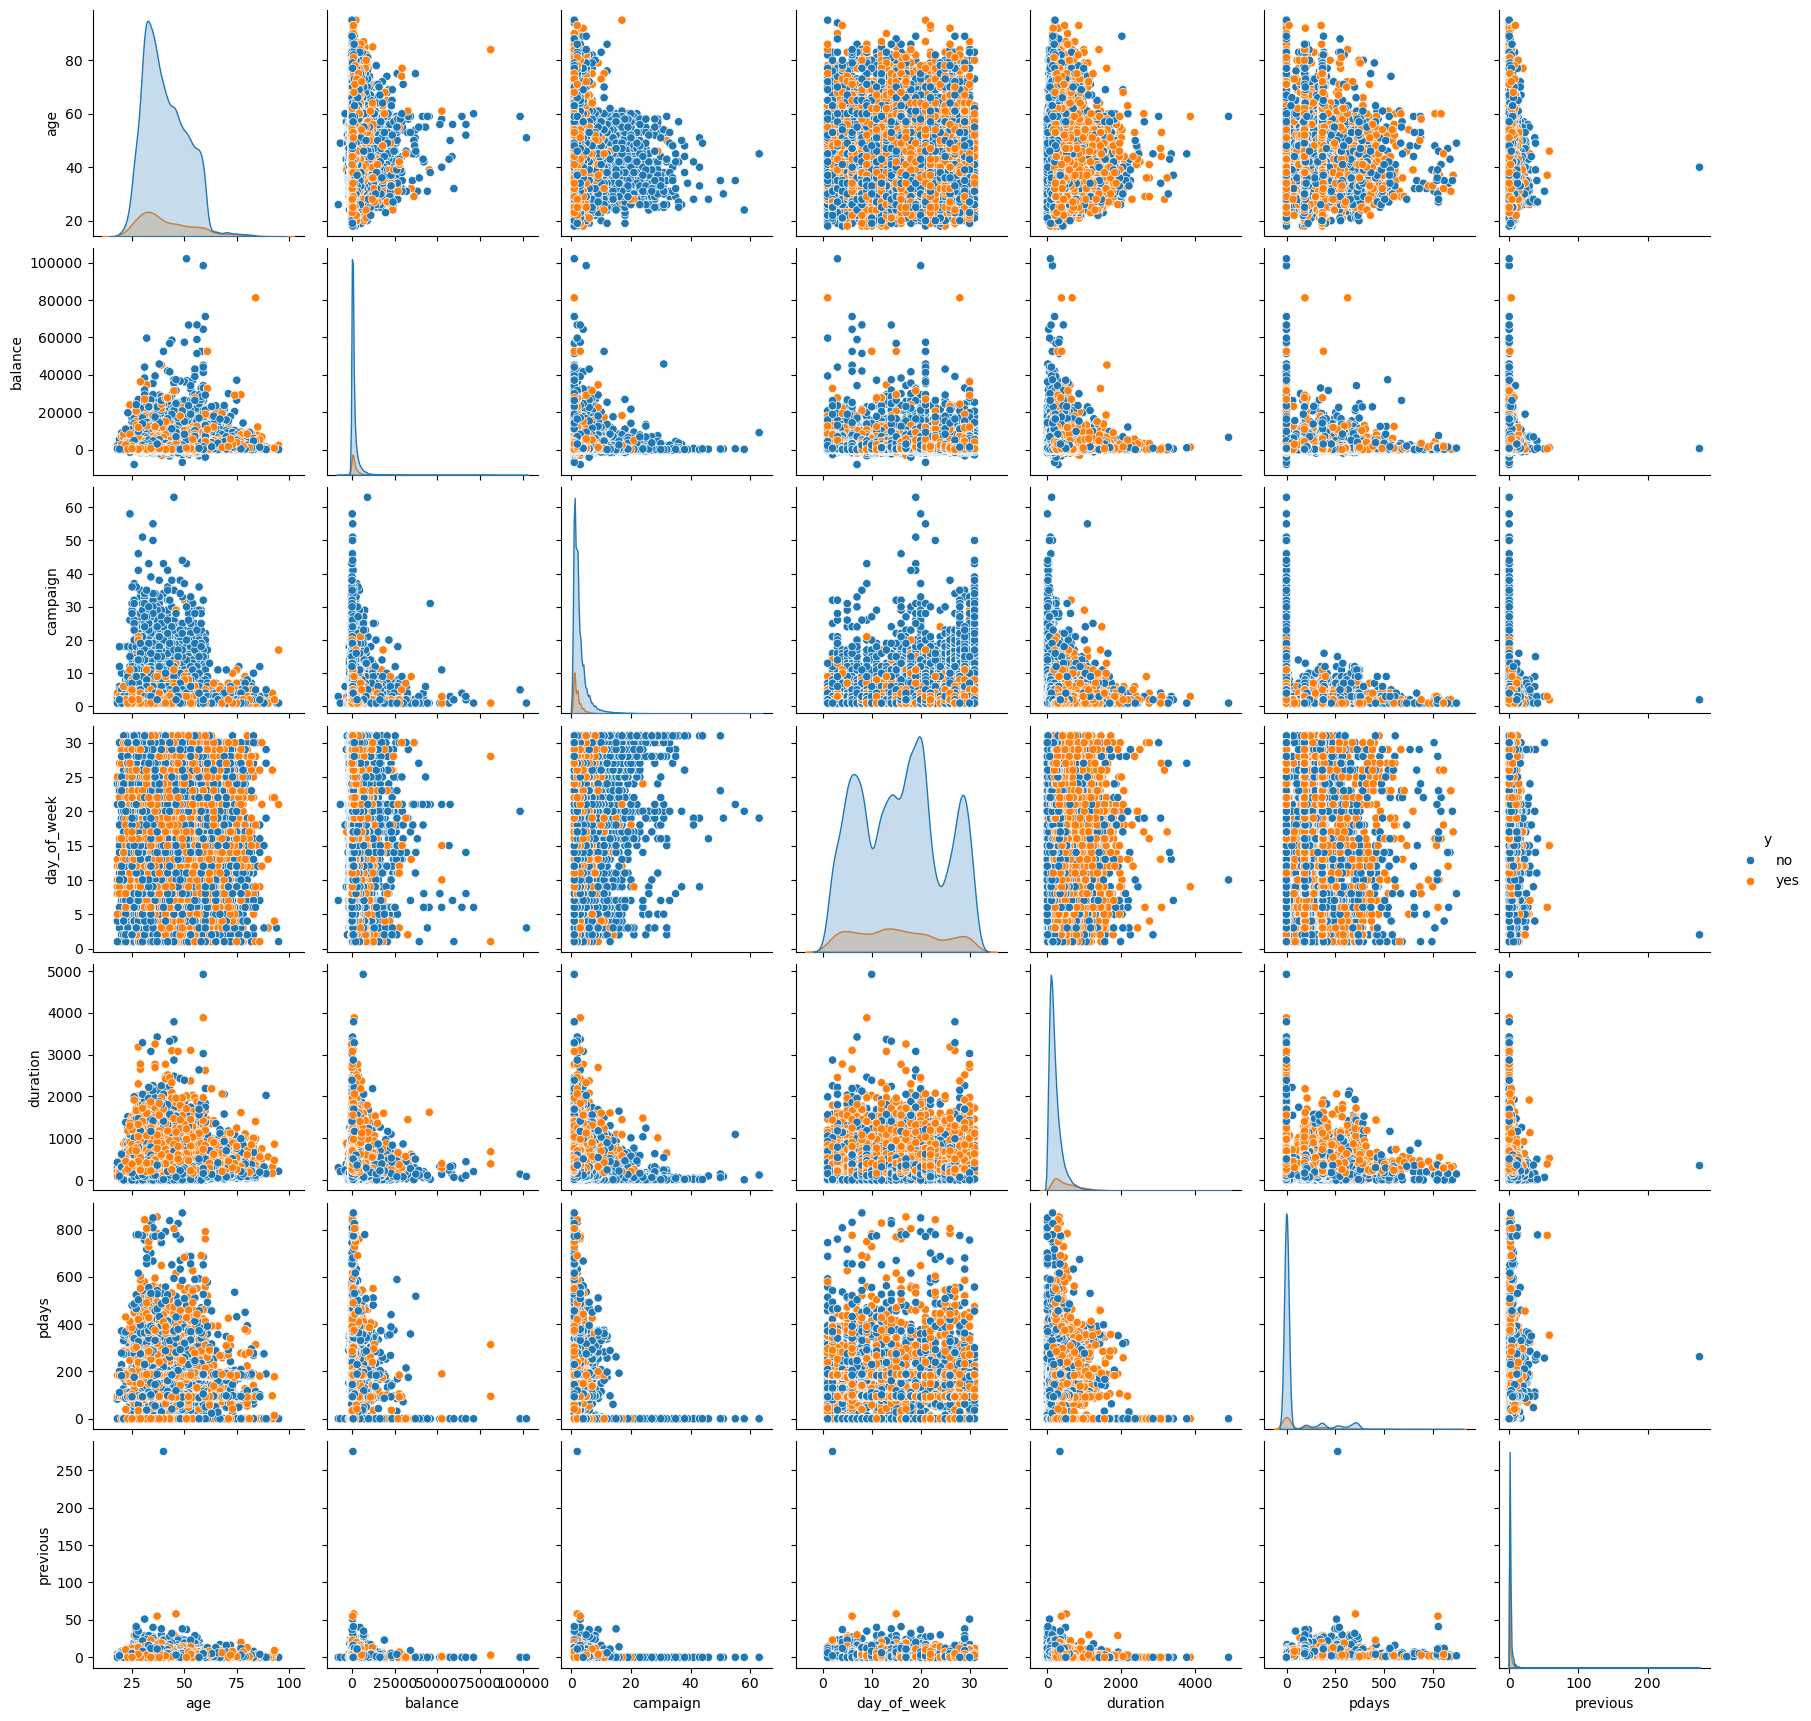

In [284]:
#Check relationship between numerical features and y
# Concatenate X and y into a single DataFrame
df = pd.concat([X, y], axis=1)  

# Get numerical columns from X (including int64 and float64)
numerical_cols = df.select_dtypes(include=['number']).columns  

# Create the pairplot
sns.pairplot(df[numerical_cols.union(['y'])], hue='y')  # Use 'target' as the hue
plt.savefig('PA3\\final\\numerical_relationships.png', dpi=300, bbox_inches='tight')
plt.show()

- No real pattern is visible in the above chart. This means the numerical features are independent
- one interesting tidbit is that there are absolutely no "Yes" answers for small durations
- The patterns for yes and no follow simialr curves across all features

# Data Manipulations

There are large amount of nulls in 'poutcome'(80%) and 'contact'(30%) features and there is no direct relationship between them and the final outcome as it is spread equally across both 'yes' and 'no'. 'contact' would hence be dropped. 'duration' has to be dropped as there is very high co-relation of duration to y as duration = 0 always results in y = 0 and there are large number of duration = 0 rows

In [217]:
#Lets check how is poutcome related to everything else
df.loc[X['poutcome'].isna(),'previous'].value_counts()

previous
0    36954
2        2
1        1
5        1
7        1
Name: count, dtype: int64

In [218]:
df.loc[X['poutcome'] == 'other','previous'].value_counts()

previous
1      591
2      390
3      238
4      165
5      107
6       64
7       59
8       46
11      27
9       27
10      19
12      17
13      16
15      10
17       9
14       7
16       6
18       5
20       5
23       5
24       4
19       4
27       3
22       3
21       2
37       2
29       2
58       1
40       1
26       1
275      1
30       1
25       1
41       1
Name: count, dtype: int64

'job' and 'education' have a small amount of nans. 

'job' > drop all records with 'NaN'

'education' > They can be rolled into the modes of those features without loosing relevant information

'poutcome' > When previous = 0, fill as 'Not Contacted', otherwise, mark as 'other'

In [240]:
X_clensed_start = X.drop(columns=['duration','contact'])
X_clensed_with_y = pd.concat([X_clensed_start, y], axis = 1)
X_clensed_with_y.dropna(subset=['job'], inplace=True)
X_clensed_with_y['education'] = X_clensed_with_y['education'].fillna(X_clensed['education'].mode()[0])
X_clensed_with_y.loc[X_clensed_with_y['previous'] == 0, 'poutcome'] = 'Not Contacted'
X_clensed_with_y['poutcome'].fillna('other')

y_clensed = X_clensed_with_y['y']
X_clensed = X_clensed_with_y.drop('y', axis = 1)

Final Dataset

In [241]:
#encode y to numeric
y_clensed = y_clensed.map({'yes':1, 'no':0})

In [242]:
#understand content of X
data_clensed_zip = zip(X_clensed.columns, X_clensed.dtypes, X_clensed.isnull().sum(), X_clensed.nunique(), np.round((X_clensed.isnull().sum()/X_clensed.shape[0])*100,2))
data_clensed_df = pd.DataFrame(data_clensed_zip, columns=['Column Name', 'Type', 'Null Count', 'Unique Count', 'Null %'])
data_clensed_df.set_index('Column Name', inplace = True)
data_clensed_df

Type  Null Count  Unique Count  Null %
Column Name                                          
age           int64           0            77    0.00
job          object           0            11    0.00
marital      object           0             3    0.00
education    object           0             3    0.00
default      object           0             2    0.00
balance       int64           0          7142    0.00
housing      object           0             2    0.00
loan         object           0             2    0.00
day_of_week   int64           0            31    0.00
month        object           0            12    0.00
campaign      int64           0            48    0.00
pdays         int64           0           558    0.00
previous      int64           0            41    0.00
poutcome     object           5             4    0.01

In [285]:
data_clensed_df.shape

(14, 4)

Now, lets split and create training and testing datasets. Lets use stratify to ensure proportional split between 'yes' and 'no' scenarios

In [244]:
#Split data. As we plan to use SMOTE for balancing, save a part of input data to check the effectiveness of final model
X_train_for_smote, X_test, y_train_for_smote, y_test = train_test_split(X_clensed,y_clensed, shuffle=True, test_size = 0.2 ,stratify=y_clensed)
X_train, X_hidden, y_train, y_hidden = train_test_split(X_train_for_smote,y_train_for_smote, shuffle=True, test_size = 0.2 ,stratify=y_train_for_smote)

In [246]:
#Build Transormer
transformer = make_column_transformer(
        (OrdinalEncoder(categories = [['primary','secondary','tertiary']], handle_unknown='use_encoded_value', unknown_value=-1), ['education']),
        (OrdinalEncoder(categories = [['jan','feb','mar', 'apr', 'may', 'jun','jul','aug','sep','oct','nov','dec']]), ['month']),
        (OneHotEncoder(drop ='if_binary', handle_unknown='ignore'),['job', 'marital','default','housing','loan','poutcome']),
        remainder=RobustScaler()   
    )

In [286]:
#Build smote - Doing this once rather than inside the pipeline due to performance limitations
smote = SMOTENC( categorical_features=[1,2,3,4,6,7,9,13],k_neighbors=3, random_state=42)

In [248]:
#smote is causing computational issues when used in pipeline. Hence, performing smote just once on the training dataset
X_train_resampled, y_train_resampled = smote.fit_resample(X_train,y_train)

In [249]:
def create_pipeline(classifier):
    pipeline = Pipeline([
        ('transform', transformer),
        ('classifier', classifier)
    ])
    return pipeline

In [250]:
# Params for KNN
params_kn = {
    'classifier__n_neighbors': [11,31,51,71,91],  # Number of neighbors
    'classifier__weights': ['uniform', 'distance'],  # Weighting scheme
    'classifier__metric': ['euclidean', 'manhattan'],  # Distance metric
}
# Params for DTree
params_dtree = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 5, 10, 20, 30],
    'classifier__min_samples_split': [0.01, 0.05, 0.1],
    'classifier__min_samples_leaf': [0.1, 0.25, 0.5]
}

# Params for LR
params_lr = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'saga'],
}
# Params for SVC - dciding to go with rbf kernel in the interst of computational efficiency
params_svc = {
    'classifier__C': [1, 10],  # Regularization parameter
    'classifier__kernel': ['rbf'],  # Kernel type - reducing due to performance limitations
    'classifier__gamma': ['scale', 'auto'],  # Kernel coefficient
}

In [251]:
def GridSearch_precision(name, params, estimator, scoring):
    estimator_clone = clone(estimator) 
    grid = GridSearchCV(estimator=create_pipeline(estimator_clone), param_grid=params, n_jobs=-1, scoring= scoring, error_score = 'raise').fit(X_train, y_train)
    model.append(name)
    train_score.append(grid.score(X_train_resampled, y_train_resampled))
    test_score.append(grid.score(X_test, y_test))
    fit_time.append(grid.cv_results_['mean_fit_time'].mean())
    score_time.append(grid.cv_results_['mean_score_time'].mean())
    return grid

For our specific scenario, precision is the best metric to optimize for that as false positives would result in inefficiencies. But 100% precision is not needed as we do need some amount of variability to also catch users who could be on the edge 

In [252]:
print(X_train_resampled.shape)
X_train_resampled.head()

(50774, 14)


age          job   marital  education default  balance housing loan  \
0   26   technician    single   tertiary      no       43     yes  yes   
1   37  blue-collar  divorced  secondary      no      625     yes   no   
2   40  blue-collar   married    primary      no      533     yes   no   
3   37     services  divorced  secondary      no      135      no   no   
4   56       admin.  divorced  secondary      no     4246     yes   no   

   day_of_week month  campaign  pdays  previous       poutcome  
0           29   jan         3    246         1        failure  
1           15   may         4    359         2        failure  
2            5   feb         4     -1         0  Not Contacted  
3           10   jul         1     -1         0  Not Contacted  
4            6   may         2     -1         0  Not Contacted

In [253]:
#Lets Calculate stats for various models
model = []
train_score=[]
test_score=[]
fit_time = []
score_time = []

grid_knn = GridSearch_precision('KNN - Default', {}, KNeighborsClassifier(),'precision')
grid_dtree = GridSearch_precision('DTree - Default', {}, DecisionTreeClassifier(),'precision')
grid_lr = GridSearch_precision('Logistics Regression - Default', {}, LogisticRegression(),'precision')
grid_svc = GridSearch_precision('SVC - Default', {}, SVC(),'precision')

In [254]:
grid_knn_p = GridSearch_precision('KNN - Tuned for Precision', params_kn, KNeighborsClassifier(), 'precision')
grid_dtree_p = GridSearch_precision('DTree - Tuned for Precision', params_dtree, DecisionTreeClassifier(), 'precision')
grid_lr_p = GridSearch_precision('Logistics Regression - Tuned for Precision', params_lr, LogisticRegression(), 'precision')
grid_svc_p = GridSearch_precision('SVC - Tuned for Precision', params_svc, SVC(), 'precision')

In [255]:
df_grid = pd.DataFrame({'model': model, 'train score':train_score, 'test score':test_score, 'fit time': fit_time, 'score time':score_time })
df_grid.set_index('model')

train score  test score  \
model                                                                 
KNN - Default                                  0.943314    0.492147   
DTree - Default                                1.000000    0.276558   
Logistics Regression - Default                 0.945908    0.733945   
SVC - Default                                  0.000000    0.000000   
KNN - Tuned for Precision                      0.945728    0.648760   
DTree - Tuned for Precision                    0.000000    0.000000   
Logistics Regression - Tuned for Precision     0.946815    0.733032   
SVC - Tuned for Precision                      0.972020    0.720207   

                                             fit time  score time  
model                                                              
KNN - Default                                0.075566    0.966929  
DTree - Default                              0.265990    0.025420  
Logistics Regression - Default               0.236806    0.022188  
SVC - Default                                7.076450    3.254661  
KNN - Tuned for Precision                    0.104419    3.300046  
DTree - Tuned for Precision                  0.088096    0.021378  
Logistics Regression - Tuned for Precision   0.926830    0.024752  
SVC - Tuned for Precision                   29.770544    3.957445

With this, we could zero in on the SVC and KNN models as the best fit for our use case as they offer best ROC/AUC which allow clear demarkation between different classes as well as the best Precision scores

In [256]:
#Lets check Recall and F1 metrics of the new model
y_pred = grid_svc_p.best_estimator_.predict(X_test)
print(f'Best SVC params - Precision :  {grid_svc_p.best_params_}')
print(f'Test Accuracy : {accuracy_score(y_test,y_pred)}')
print(f'Test Recall  : {recall_score(y_test,y_pred)}')
print(f'Test F1 : {f1_score(y_test,y_pred)}')
print(f'Test Precision : {precision_score(y_test,y_pred)}')

Best SVC params - Precision :  {'classifier__C': 1, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}
Test Accuracy : 0.8924874791318865
Test Recall  : 0.13225499524262607
Test F1 : 0.22347266881028938
Test Precision : 0.7202072538860104


In [257]:
# Lets Do the same for the best KNN model as well
y_pred = grid_knn_p.best_estimator_.predict(X_test)
print(f'Best KNN params - Precision :  {grid_knn_p.best_params_}')
print(f'Test Accuracy : {accuracy_score(y_test,y_pred)}')
print(f'Test Recall : {recall_score(y_test,y_pred)}')
print(f'Test F1 : {f1_score(y_test,y_pred)}')
print(f'Test Precision : {precision_score(y_test,y_pred)}')

Best KNN params - Precision :  {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 31, 'classifier__weights': 'uniform'}
Test Accuracy : 0.8910406232609905
Test Recall : 0.1493815413891532
Test F1 : 0.242846094354215
Test Precision : 0.6487603305785123


KNN tuned for precision has the best test precision score, which is very close to the test SVC, the other scores being very comparable. Some more tuning is needed before we finalize this

Evaluating the SVC model further to see if the thresholds being considered can be tuned to find a better model

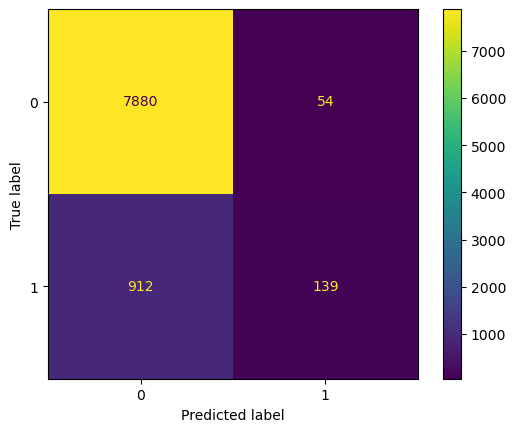

In [258]:
#Lets Check the confusion Matrix for the current model
y_pred = grid_svc_p.best_estimator_.predict(X_test)

#Genearte confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_svc_p.best_estimator_.classes_)

disp.plot()
plt.show()

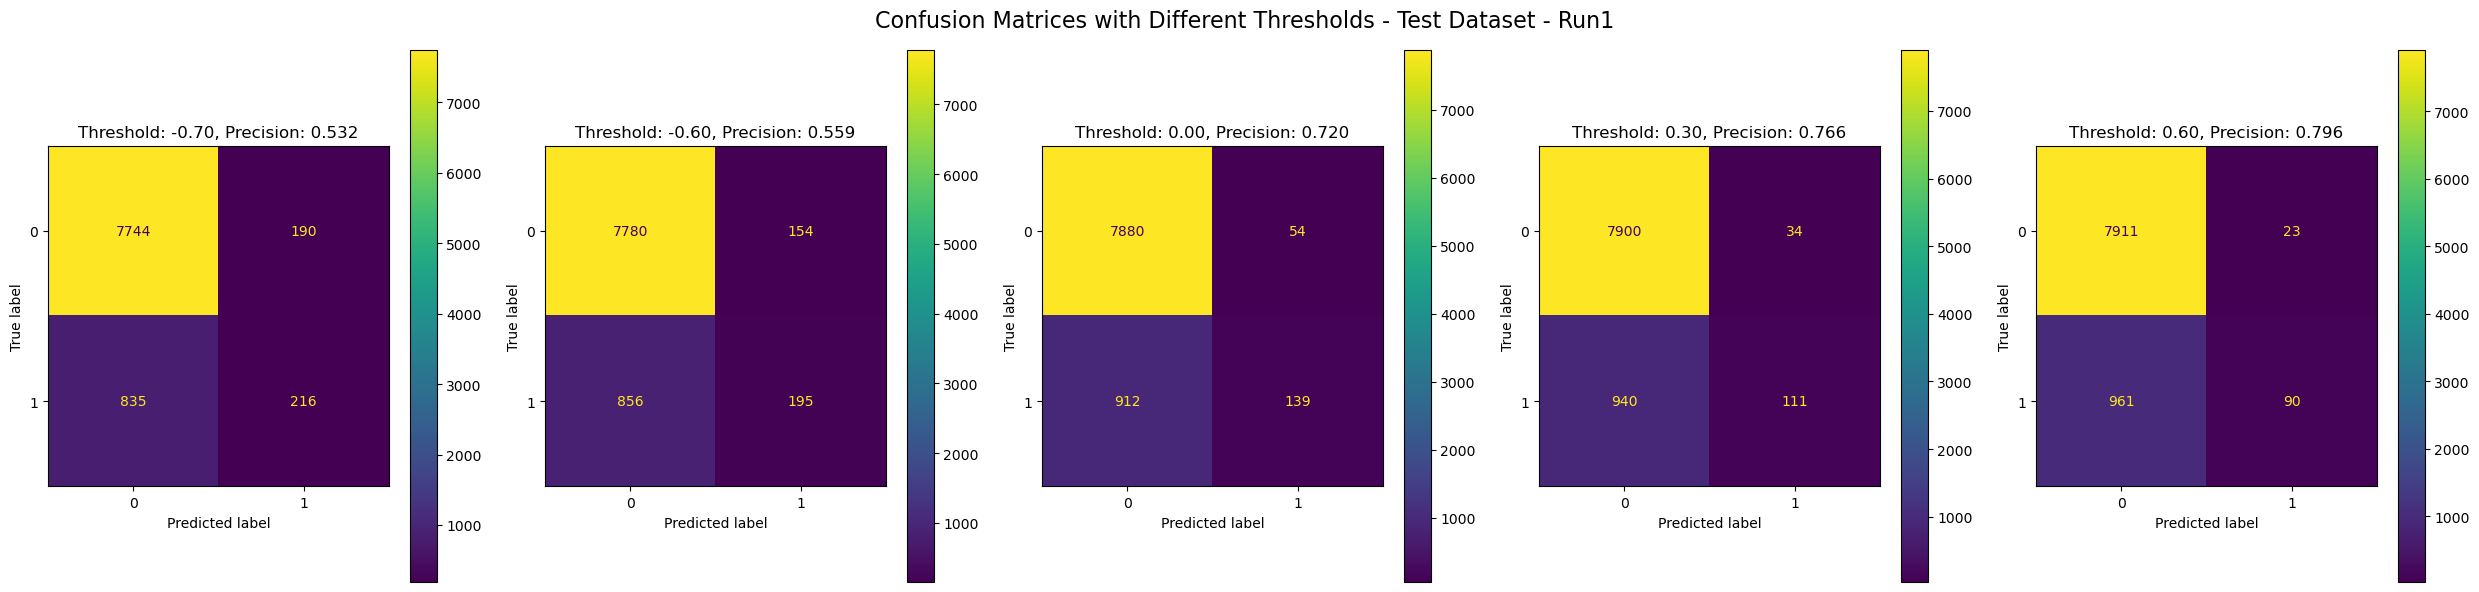

In [295]:
# Adjust Decision Threshold to see if SVC can be better than KNN
thresholds_to_check = [-0.7,-0.6,0,0.3,0.6]

# Create subplots for 5 plots in a line
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 6)) 

#model to check
model = grid_svc_p.best_estimator_

y_scores = model.decision_function(X_test)  

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
fig.suptitle('Confusion Matrices with Different Thresholds - Test Dataset - Run1', fontsize = 16)

# Loop through target precision values
for i, threshold in enumerate(thresholds_to_check):
    y_pred_adjusted = np.where((y_scores >= threshold).astype(int) == 1, 1, 0)
    
    # Calculate precision
    precision = precision_score(y_test, y_pred_adjusted)
    
    # Generate the confusion matrix
    cm_adjusted = confusion_matrix(y_test, y_pred_adjusted)
    disp_adjusted = ConfusionMatrixDisplay(confusion_matrix=cm_adjusted, display_labels=model.classes_)
    disp_adjusted.plot(ax=axes[i])
    
    axes[i].set_title(f'Threshold: {threshold:.2f}, Precision: {precision:.3f}')

plt.savefig('PA3\\final\\cm_test_run1.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

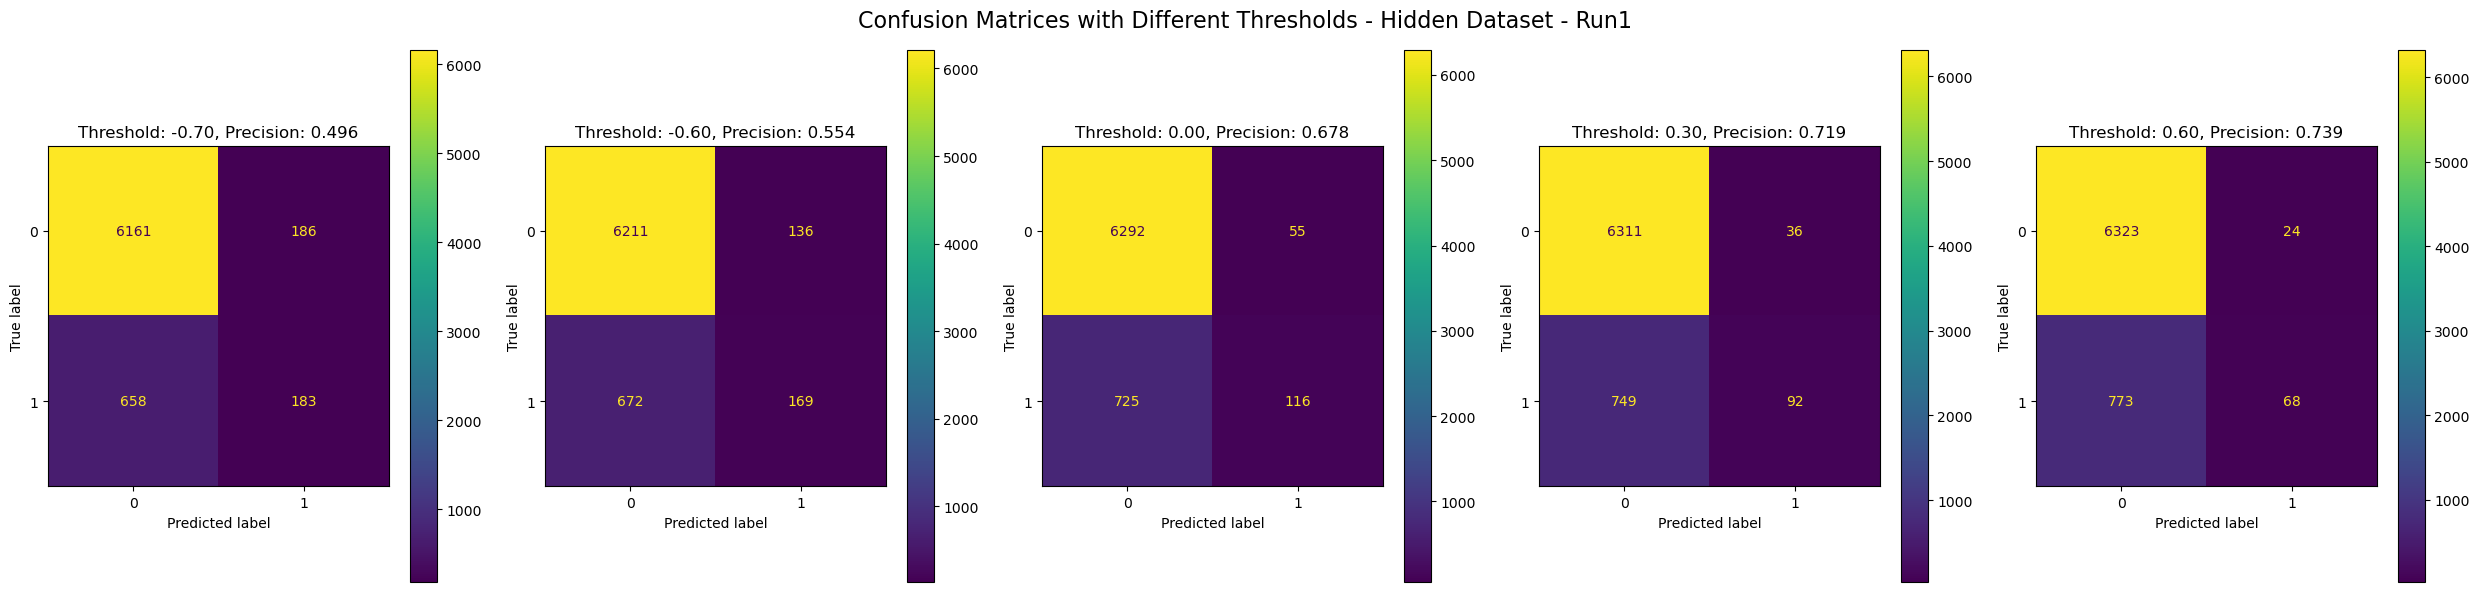

In [297]:
# Get predicted probabilities
model = grid_svc_p.best_estimator_
y_scores = model.decision_function(X_hidden)  
thresholds_to_check = [-0.7,-0.6,0,0.3,0.6]

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_hidden, y_scores)

# Create subplots for 5 plots in a line
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 6)) 
fig.suptitle('Confusion Matrices with Different Thresholds - Hidden Dataset - Run1', fontsize = 16)

# Loop through target precision values
for i, threshold in enumerate(thresholds_to_check):
    y_pred_adjusted = np.where((y_scores >= threshold).astype(int) == 1, 1, 0)

    # Calculate precision
    precision = precision_score(y_hidden, y_pred_adjusted)

    # Generate the confusion matrix
    cm_adjusted = confusion_matrix(y_hidden, y_pred_adjusted)
    disp_adjusted = ConfusionMatrixDisplay(confusion_matrix=cm_adjusted, display_labels=model.classes_)
    disp_adjusted.plot(ax=axes[i])

    # Set the title with precision score
    axes[i].set_title(f'Threshold: {threshold:.2f}, Precision: {precision:.3f}')

plt.savefig('PA3\\final\\cm_hidden_run1.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

What we notice here is that as the threshold increases, the number of false positives decrese, but, the true positve also decreses at the same rate. That means, we will miss a lot of valid customers as well. Let us tune it a bit further and see if this can be improved upon

Continuing tuning with the two best models identified so far

In [261]:
# Params for KNN
params_kn_2 = {
    'classifier__n_neighbors': [55,65,70,75,80,85],  # Number of neighbors
    'classifier__weights': ['uniform', 'distance'],  # Weighting scheme
    'classifier__metric': ['euclidean', 'manhattan'],  # Distance metric
}

# Params for SVC 
params_svc_2 = {
    'classifier__C': [0.1, 10],  # Regularization parameter
    'classifier__kernel': ['rbf'],  # Kernel type
    'classifier__gamma': [0.001,0.01,0.1,1],  # Kernel coefficient
}

params_dtree_2 = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [10,20,25,30],
    'classifier__min_samples_split': [0.1,0.2],
    'classifier__min_samples_leaf': [10,100,1000]
}

In [262]:
model = []
train_score=[]
test_score=[]
fit_time = []
score_time = []

grid_dtree_p2 = GridSearch_precision('Dtree - Further Tuned for Precision', params_dtree_2, DecisionTreeClassifier(), 'precision')
grid_knn_p2 = GridSearch_precision('KNN - Further Tuned for Precision', params_kn_2, KNeighborsClassifier(), 'precision')
grid_svc_p2 = GridSearch_precision('SVC - Further Tuned for Precision', params_svc_2, SVC(), 'precision')

In [263]:
y_pred = grid_dtree_p2.best_estimator_.predict(X_test)
print(f'Best DTree params - Precision :  {grid_dtree_p2.best_params_}')
print(f'Test Accuracy : {accuracy_score(y_test,y_pred)}')
print(f'Test Recall : {recall_score(y_test,y_pred)}')
print(f'Test F1 : {f1_score(y_test,y_pred)}')
print(f'Test Precision : {precision_score(y_test,y_pred)}')

Best DTree params - Precision :  {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 0.1}
Test Accuracy : 0.8936004451864218
Test Recall : 0.1731684110371075
Test F1 : 0.27575757575757576
Test Precision : 0.6765799256505576


In [264]:
y_pred = grid_knn_p2.best_estimator_.predict(X_test)
print(f'Best KNN params - Precision :  {grid_knn_p2.best_params_}')
print(f'Test Accuracy : {accuracy_score(y_test,y_pred)}')
print(f'Test Recall : {recall_score(y_test,y_pred)}')
print(f'Test F1 : {f1_score(y_test,y_pred)}')
print(f'Test Precision : {precision_score(y_test,y_pred)}')

Best KNN params - Precision :  {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 65, 'classifier__weights': 'distance'}
Test Accuracy : 0.8897050639955482
Test Recall : 0.13891531874405327
Test F1 : 0.22759158222915044
Test Precision : 0.6293103448275862


In [265]:
y_pred = grid_svc_p2.best_estimator_.predict(X_test)
print(f'Best SVC params - Precision :  {grid_svc_p2.best_params_}')
print(f'Test Accuracy : {accuracy_score(y_test,y_pred)}')
print(f'Test Recall  : {recall_score(y_test,y_pred)}')
print(f'Test F1 : {f1_score(y_test,y_pred)}')
print(f'Test Precision : {precision_score(y_test,y_pred)}')

Best SVC params - Precision :  {'classifier__C': 0.1, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}
Test Accuracy : 0.8852531997774068
Test Recall  : 0.02093244529019981
Test F1 : 0.04093023255813953
Test Precision : 0.9166666666666666


In [37]:
df_grid2 = pd.DataFrame({'model': model, 'train score':train_score, 'test score':test_score, 'fit time': fit_time, 'score time':score_time })
df_grid2.set_index('model')

train score  test score   fit time  \
model                                                                     
Dtree - Further Tuned for Precision     0.913016    0.514286   0.145329   
KNN - Further Tuned for Precision       1.000000    0.689139   0.084070   
SVC - Further Tuned for Precision       0.946909    0.651899  32.885939   

                                     score time  
model                                            
Dtree - Further Tuned for Precision    0.023335  
KNN - Further Tuned for Precision      4.293043  
SVC - Further Tuned for Precision      5.357418

In [266]:
df_grid_eval = pd.concat([df_grid,df_grid2]).set_index('model')
df_grid_eval

train score  test score  \
model                                                                 
KNN - Default                                  0.943314    0.492147   
DTree - Default                                1.000000    0.276558   
Logistics Regression - Default                 0.945908    0.733945   
SVC - Default                                  0.000000    0.000000   
KNN - Tuned for Precision                      0.945728    0.648760   
DTree - Tuned for Precision                    0.000000    0.000000   
Logistics Regression - Tuned for Precision     0.946815    0.733032   
SVC - Tuned for Precision                      0.972020    0.720207   
Dtree - Further Tuned for Precision            0.913016    0.514286   
KNN - Further Tuned for Precision              1.000000    0.689139   
SVC - Further Tuned for Precision              0.946909    0.651899   

                                             fit time  score time  
model                                                              
KNN - Default                                0.075566    0.966929  
DTree - Default                              0.265990    0.025420  
Logistics Regression - Default               0.236806    0.022188  
SVC - Default                                7.076450    3.254661  
KNN - Tuned for Precision                    0.104419    3.300046  
DTree - Tuned for Precision                  0.088096    0.021378  
Logistics Regression - Tuned for Precision   0.926830    0.024752  
SVC - Tuned for Precision                   29.770544    3.957445  
Dtree - Further Tuned for Precision          0.145329    0.023335  
KNN - Further Tuned for Precision            0.084070    4.293043  
SVC - Further Tuned for Precision           32.885939    5.357418

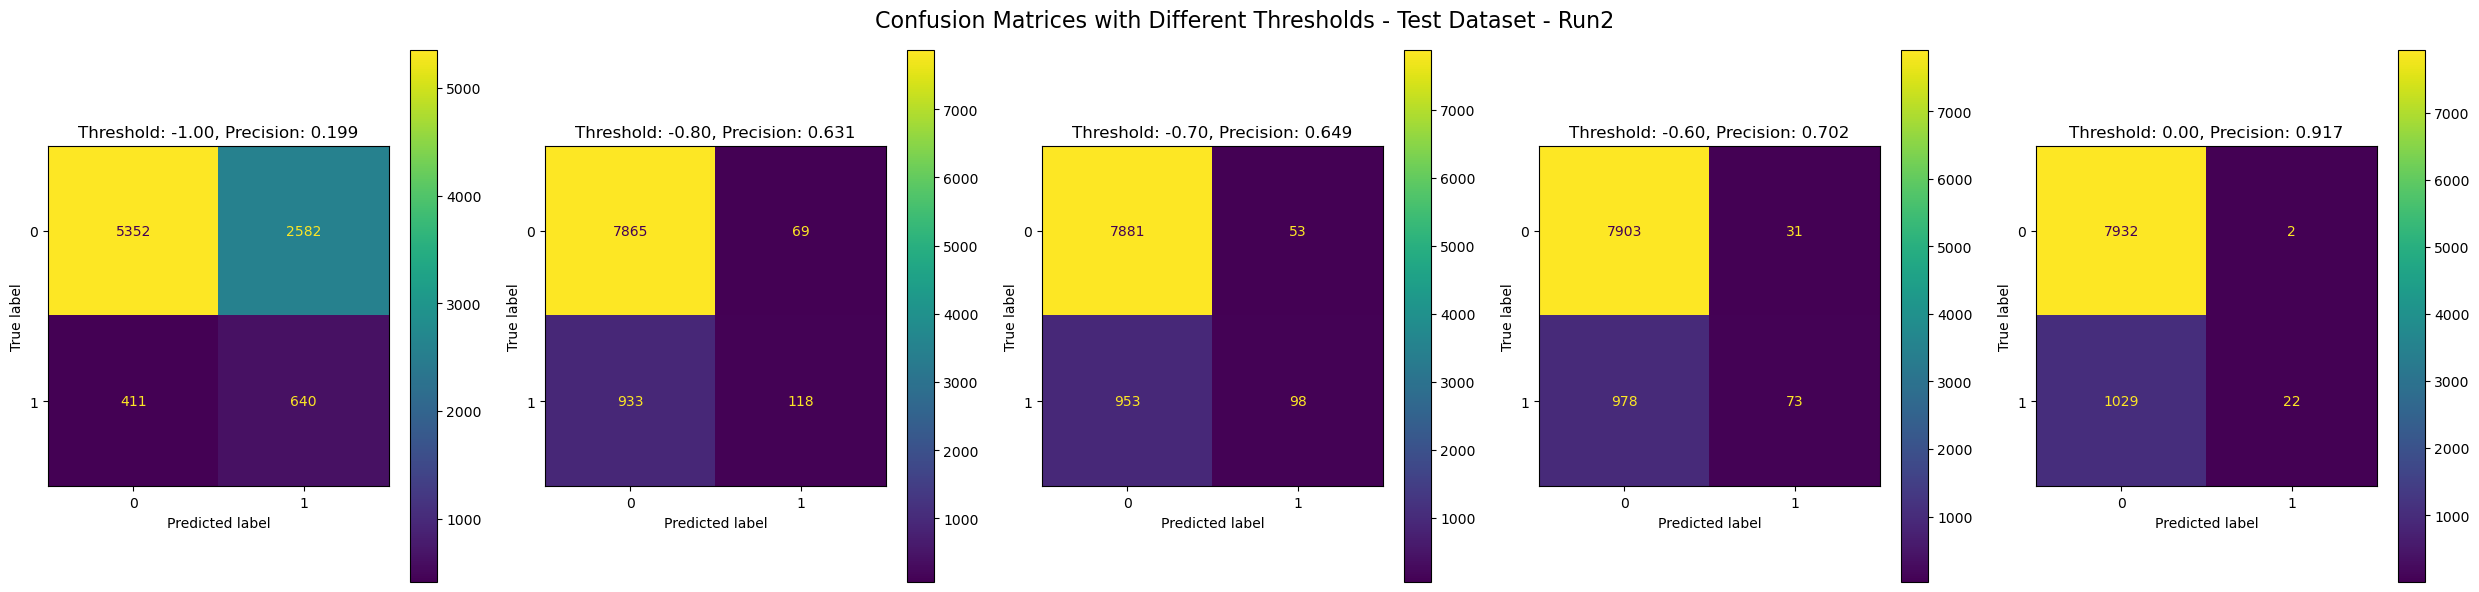

In [291]:
# Get predicted probabilities on Hidden dataset to see if there is any improvements from the initial models
model = grid_svc_p2.best_estimator_
y_scores = model.decision_function(X_test)  
thresholds_to_check = [-1,-0.8,-0.7,-0.6,0]

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Create subplots for 5 plots in a line
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 6)) 
fig.suptitle('Confusion Matrices with Different Thresholds - Test Dataset - Run2', fontsize = 16)

# Loop through target precision values
for i, threshold in enumerate(thresholds_to_check):
    y_pred_adjusted = np.where((y_scores >= threshold).astype(int) == 1, 1, 0)

    # Calculate precision
    precision = precision_score(y_test, y_pred_adjusted)

    # Generate the confusion matrix
    cm_adjusted = confusion_matrix(y_test, y_pred_adjusted)
    disp_adjusted = ConfusionMatrixDisplay(confusion_matrix=cm_adjusted, display_labels=model.classes_)
    disp_adjusted.plot(ax=axes[i])

    # Set the title with precision score
    axes[i].set_title(f'Threshold: {threshold:.2f}, Precision: {precision:.3f}')

plt.savefig('PA3\\final\\cm_test_run2.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [ ]:
# Get predicted probabilities on Hidden dataset to see if there is any improvements from the initial models
model = grid_svc_p2.best_estimator_
y_scores = model.decision_function(X_hidden)  
thresholds_to_check = [-1,-0.8,-0.7,-0.6,0]

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_hidden, y_scores)

# Create subplots for 5 plots in a line
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 6)) 
fig.suptitle('Confusion Matrices with Different Thresholds - Hidden Dataset - Run2', fontsize = 16)

# Loop through target precision values
for i, threshold in enumerate(thresholds_to_check):
    y_pred_adjusted = np.where((y_scores >= threshold).astype(int) == 1, 1, 0)

    # Calculate precision
    precision = precision_score(y_hidden, y_pred_adjusted)

    # Generate the confusion matrix
    cm_adjusted = confusion_matrix(y_hidden, y_pred_adjusted)
    disp_adjusted = ConfusionMatrixDisplay(confusion_matrix=cm_adjusted, display_labels=model.classes_)
    disp_adjusted.plot(ax=axes[i])

    # Set the title with precision score
    axes[i].set_title(f'Threshold: {threshold:.2f}, Precision: {precision:.3f}')

plt.savefig('PA3\\final\\cm_hidden_run2.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

## Evaluate Best model

There are two models to evaluate. The SVC model from run1(0.3 threshold) and then again from run2(-0.7 threshold). They both have good precision scores. Lets compare a few more of them side by side to see how it looks

In [269]:
def predict_with_threshold(model, X, threshold):
    """
    Predicts using the SVC model with an adjusted decision threshold.

    Args:
      model: The model used for prediction
      X: The data for prediction (DataFrame or array).
      threshold: Threshold for calculation (float)

    Returns:
      Predictions for the data (array of 1 and 0).
    """    
    y_scores = model.decision_function(X)
    y_pred_adjusted = (y_scores >= threshold).astype(int)
    
    return y_pred_adjusted

In [300]:
#Get various scores from the best model for test and hidden data sets
groups = []
thresholds_list = []
precision_list = []
accuracy_list = []
f1_list = []
recall_list = []

model = grid_svc_p.best_estimator_
for threshold in [-0.8,-0.7,0,0.3,0.6]:

    y_pred = predict_with_threshold(model, X_test, threshold)
    groups.append('Test - run1')
    thresholds_list.append(threshold)
    accuracy_list.append(accuracy_score(y_test, y_pred))
    recall_list.append(recall_score(y_test, y_pred))
    precision_list.append(precision_score(y_test,y_pred))
    f1_list.append(f1_score(y_test,y_pred))

    y_pred = predict_with_threshold(model, X_hidden, threshold)
    groups.append('Hidden - run1')
    thresholds_list.append(threshold)
    accuracy_list.append(accuracy_score(y_hidden, y_pred))
    recall_list.append(recall_score(y_hidden, y_pred))
    precision_list.append(precision_score(y_hidden,y_pred))
    f1_list.append(f1_score(y_hidden,y_pred))


In [302]:
model = grid_svc_p2.best_estimator_
for threshold in [-0.8,-0.7,0,0.3,0.6]:

    y_pred = predict_with_threshold(model, X_test, threshold)
    groups.append('Test - run2')
    thresholds_list.append(threshold)
    accuracy_list.append(accuracy_score(y_test, y_pred))
    recall_list.append(recall_score(y_test, y_pred))
    precision_list.append(precision_score(y_test,y_pred))
    f1_list.append(f1_score(y_test,y_pred))

    y_pred = predict_with_threshold(model, X_hidden, threshold)
    groups.append('Hidden - run2')
    thresholds_list.append(threshold)
    accuracy_list.append(accuracy_score(y_hidden, y_pred))
    recall_list.append(recall_score(y_hidden, y_pred))
    precision_list.append(precision_score(y_hidden,y_pred))
    f1_list.append(f1_score(y_hidden,y_pred))

In [303]:
results_df = pd.DataFrame({
    'Group': groups,
    'Threshold': thresholds_list,
    'Precision': precision_list,
    'Accuracy': accuracy_list,
    'Recall': recall_list,
    'F1': f1_list
})
results_df.set_index(['Threshold','Group']).sort_values(['Precision'],ascending=[False])

Precision  Accuracy    Recall        F1
Threshold Group                                                 
 0.6      Hidden - run2   1.000000  0.883139  0.001189  0.002375
          Test - run2     1.000000  0.883250  0.001903  0.003799
 0.3      Test - run2     1.000000  0.884140  0.009515  0.018850
 0.0      Test - run2     0.916667  0.885253  0.020932  0.040930
 0.6      Test - run1     0.796460  0.890484  0.085633  0.154639
 0.0      Hidden - run2   0.777778  0.884391  0.016647  0.032596
 0.3      Hidden - run2   0.777778  0.883695  0.008323  0.016471
          Test - run1     0.765517  0.891597  0.105614  0.185619
 0.6      Hidden - run1   0.739130  0.889121  0.080856  0.145766
-0.7      Hidden - run2   0.724771  0.889816  0.093936  0.166316
 0.0      Test - run1     0.720207  0.892487  0.132255  0.223473
 0.3      Hidden - run1   0.718750  0.890790  0.109394  0.189886
 0.0      Hidden - run1   0.678363  0.891486  0.137931  0.229249
-0.8      Hidden - run2   0.652482  0.888982  0.109394  0.187373
-0.7      Test - run2     0.649007  0.888036  0.093245  0.163062
-0.8      Test - run2     0.631016  0.888481  0.112274  0.190630
-0.7      Test - run1     0.532020  0.885921  0.205519  0.296500
-0.8      Test - run1     0.502165  0.883250  0.220742  0.306675
-0.7      Hidden - run1   0.495935  0.882582  0.217598  0.302479
-0.8      Hidden - run1   0.466357  0.878965  0.239001  0.316038

Based on these evaluations, the best model we can find with the current computational limits is SVC - Tuned for Precision with threshold updated to 0.3, which gives a precision score of 0.77 on the test dataset and 0.71 on the hidden dataset with a comparitively higher F1 score.
The alternate is the KNN that is tuned for precision, but, there is a risk of overfit. Hence, even though SVC is more expensive, we will use the tuned SVC to model this dataset for this usecase

In [304]:
selected_threshold = 0.3
selected_model = grid_svc_p.best_estimator_

In [305]:
#Now, let us try and infer the output of the SVC using permutation importance
from sklearn.inspection import permutation_importance

# Create a dummy estimator class with a fit method
class DummyEstimator:
    def __init__(self, func, threshold, model):
        self.func = func
        self.threshold = threshold
        self.model = model

    def fit(self, X, y=None):
        return self

    def predict(self, X):
        return self.func(self.model,X, self.threshold)

estimator = DummyEstimator(predict_with_threshold, selected_threshold, selected_model)
pim = permutation_importance(estimator, X_hidden, y_hidden, n_repeats=10, n_jobs = -1, random_state=42, scoring=precision_scorer) #Using hidden dataset here to udnerstand impact on unseen data
for i, feature in enumerate(X_clensed.columns):
    print(f'{feature}: {pim.importances_mean[i]}')

age: -0.0033335238171257275
job: -0.016334075028412144
marital: 0.002352215028618554
education: -0.0016054053339486286
default: 0.00022145669291339097
balance: -0.00872699214697259
housing: -0.013127874742224344
loan: -0.003719356682885555
day_of_week: -0.0025546389614604648
month: 0.0474600221476834
campaign: 0.01323503189438815
pdays: 0.4325032965119172
previous: -0.0084432990525668
poutcome: 0.04336629345461516


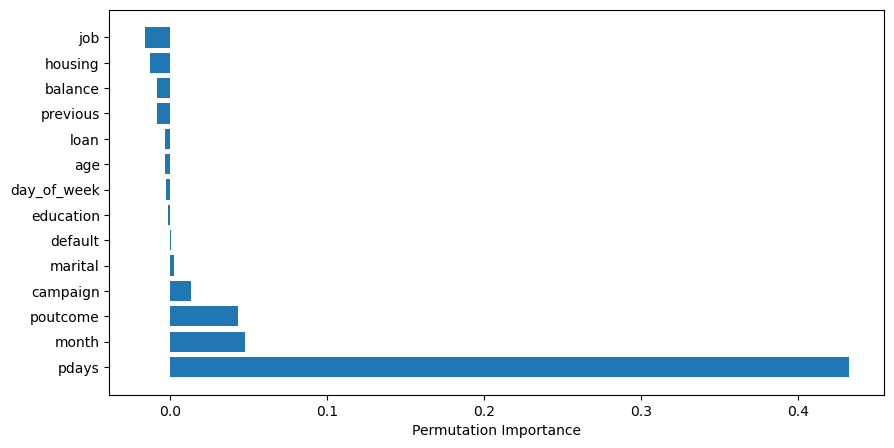

In [314]:
sorted_idx = pim.importances_mean.argsort()[::-1]  # Get indices that would sort the array
importance_sorted = pim.importances_mean[sorted_idx]
features_sorted = X_hidden.columns[sorted_idx]

plt.figure(figsize=(10, 5))
plt.barh(features_sorted, importance_sorted)
plt.xlabel("Permutation Importance")
plt.savefig('PA3\\final\\permutation_importance.png', dpi=300, bbox_inches='tight')
plt.show()

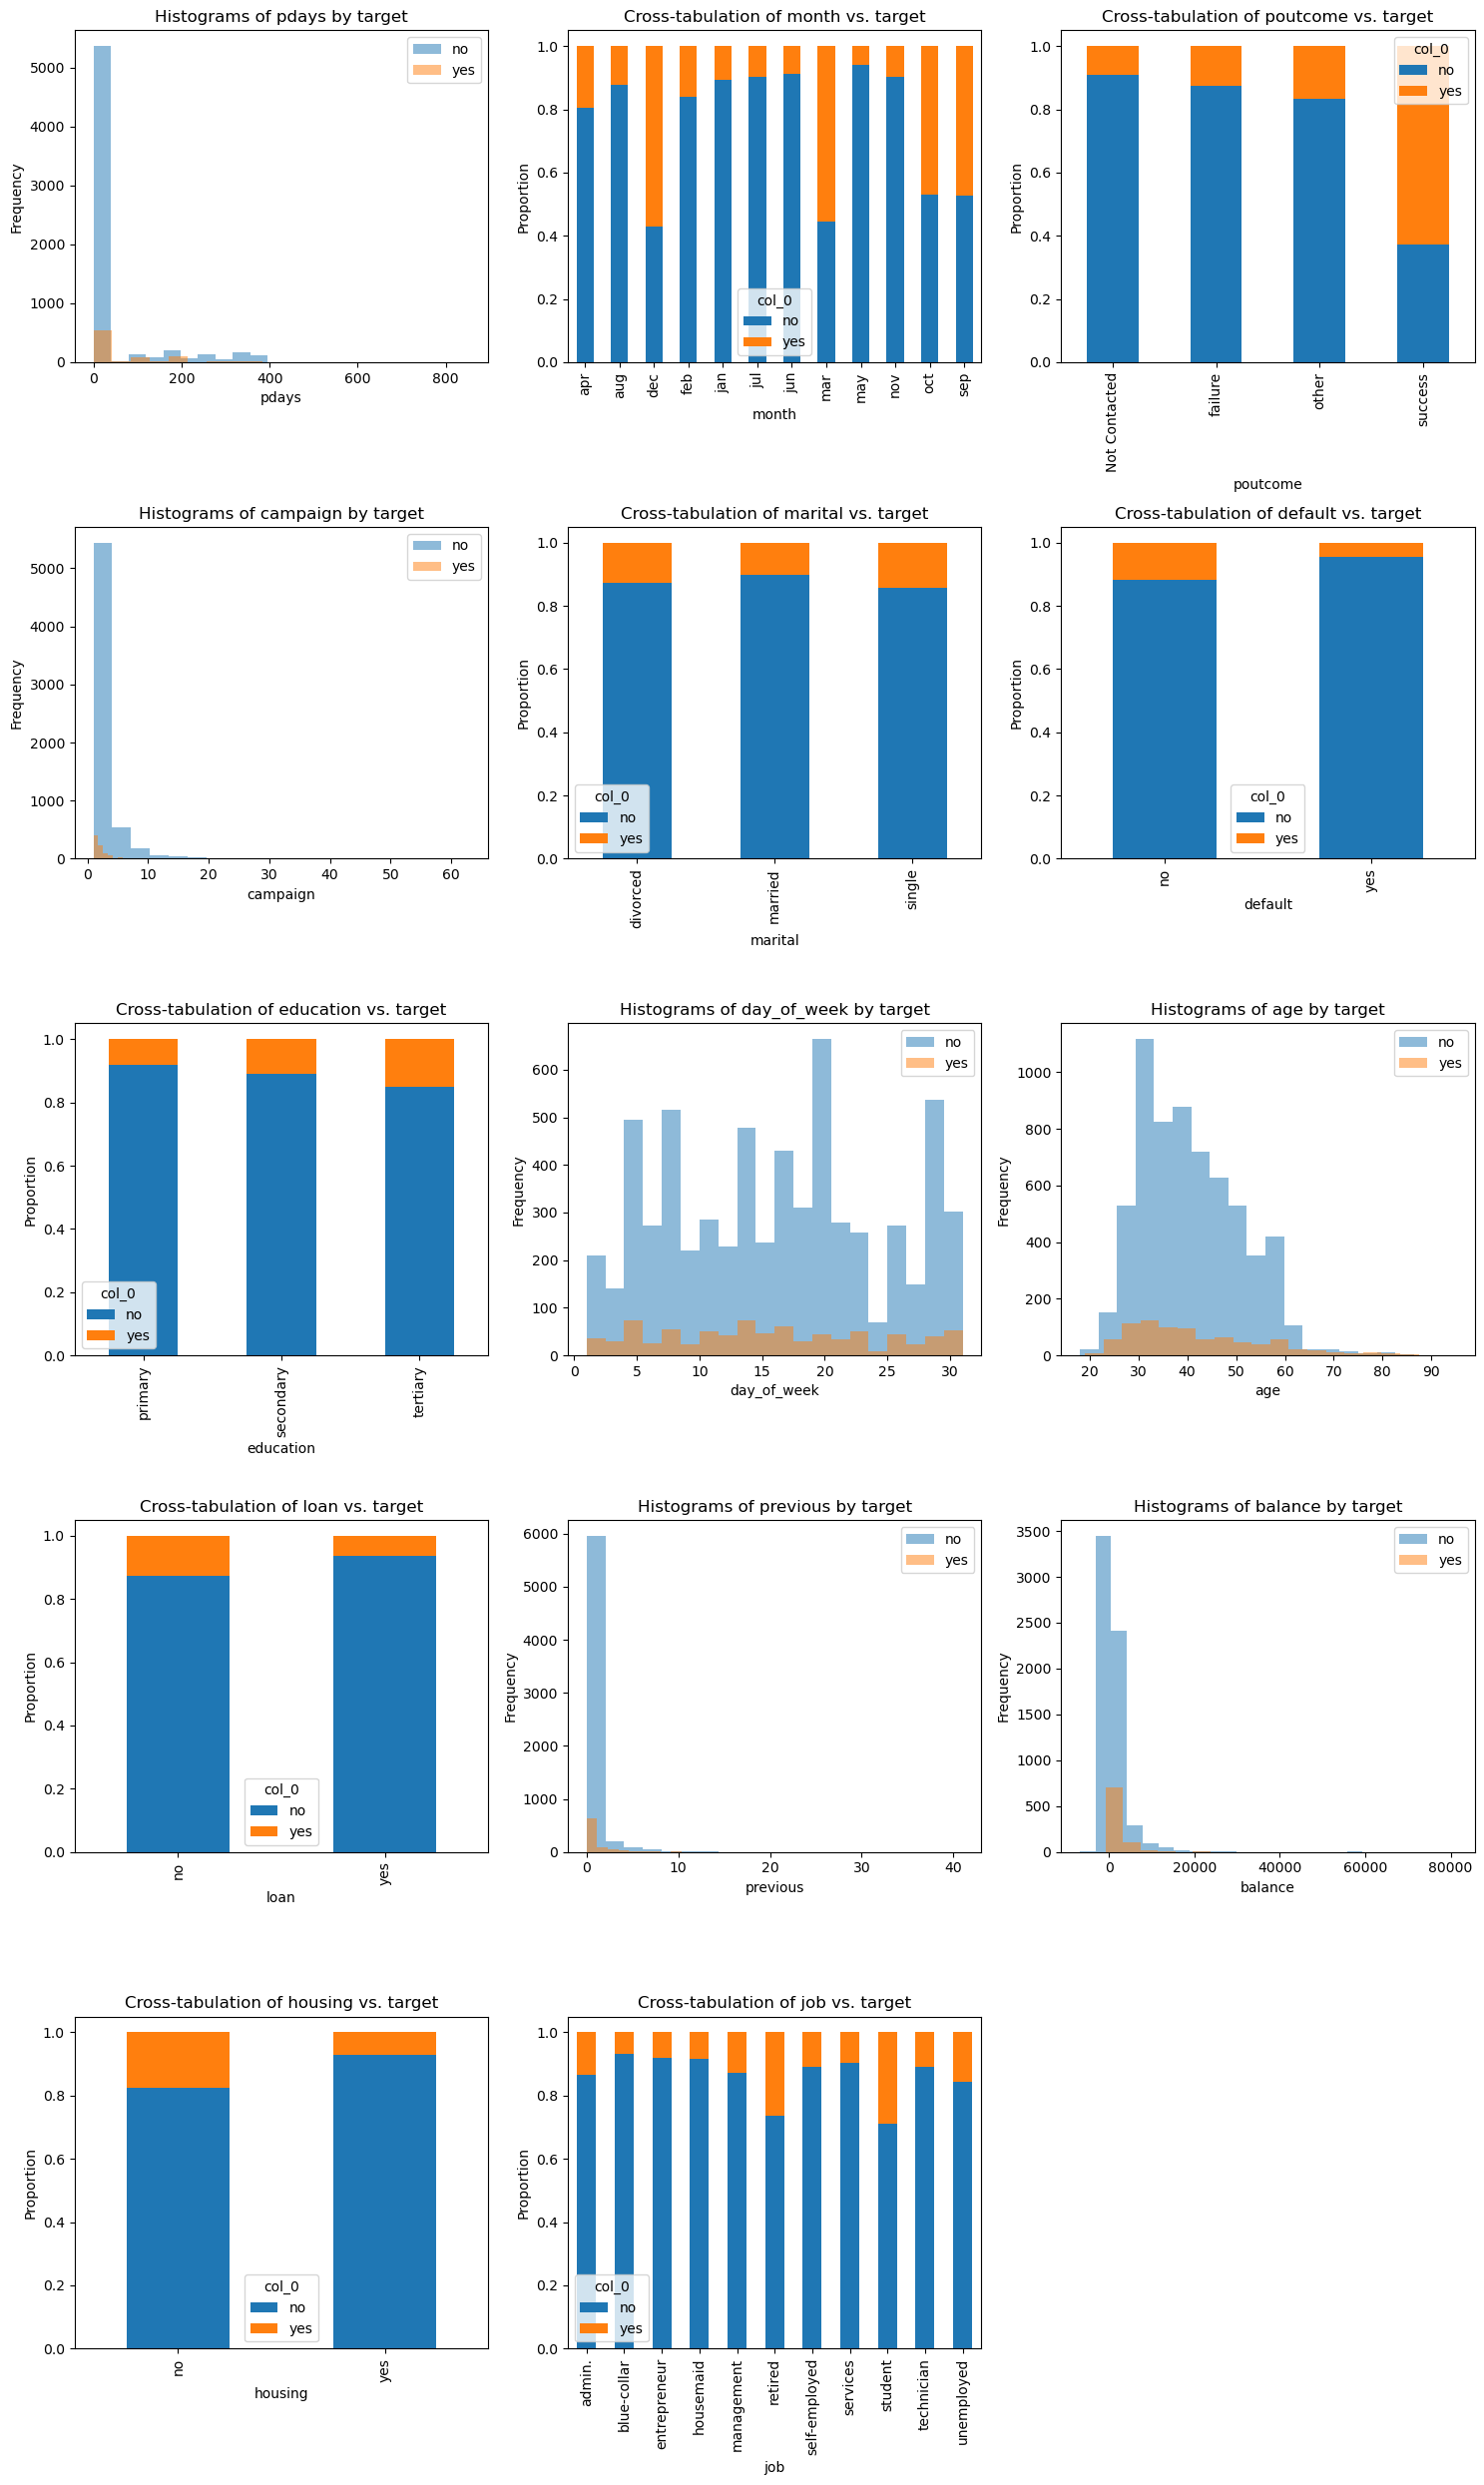

In [307]:
# Separate categorical and numerical features
categorical_features = X_hidden.select_dtypes(include=['object', 'category']).columns
numerical_features = X_hidden.select_dtypes(include=['number']).columns

# Calculate the number of rows needed for the subplots
num_rows = (len(features_sorted) + 2) // 3

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5 * num_rows))
axes = axes.flatten()
y_strings = np.where(y_hidden == 1, 'yes', 'no')
# Loop through features and create plots
for i, feature in enumerate(features_sorted):
    if feature in categorical_features:
        # Categorical feature: Create cross-tabulation plot
        cross_tab = pd.crosstab(X_hidden[feature], y_strings, normalize='index')
        cross_tab.plot(kind='bar', stacked=True, ax=axes[i])
        axes[i].set_title(f"Cross-tabulation of {feature} vs. target")
        axes[i].set_ylabel("Proportion")

    elif feature in numerical_features:
        # Numerical feature: Create cross-histograms with buckets
        axes[i].hist(X_hidden[y_hidden == 0][feature], alpha=0.5, bins=20,  label='no')
        axes[i].hist(X_hidden[y_hidden == 1][feature], alpha=0.5, bins=20, label='yes')
        axes[i].set_title(f"Histograms of {feature} by target")
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel("Frequency")
        axes[i].legend()

# Remove any unused subplots
for i in range(len(features_sorted), len(axes)):
    fig.delaxes(axes[i])


plt.tight_layout()
plt.savefig('PA3\\final\\feature_importance_spread_hidden.png', dpi=300, bbox_inches='tight')
plt.show()

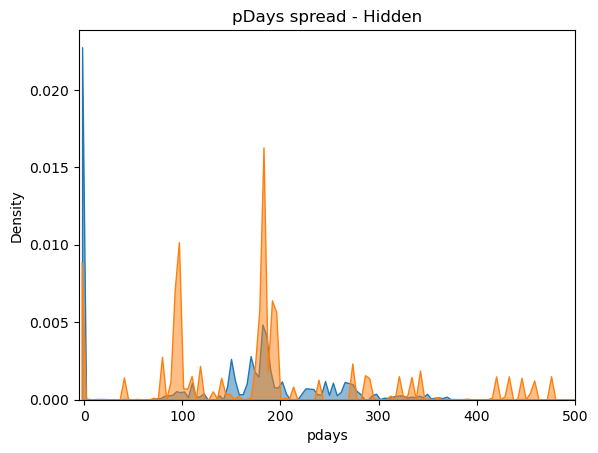

In [317]:
#To better visualize pdays spread
feature = 'pdays'
sns.kdeplot(X_hidden[y_hidden == 0][feature],bw_adjust=0.01, fill=True, alpha=0.5,  label='no')
sns.kdeplot(X_hidden[y_hidden == 1][feature],bw_adjust=0.01, fill=True, alpha=0.5, label='yes')

plt.title('pDays spread - Hidden')
plt.xlim(-5,500) 
plt.savefig('PA3\\final\\feature_importance_pdays.png', dpi=300, bbox_inches='tight')
plt.show()

within pdays, the the early part 0-10 days has the most impact on the final prediction!

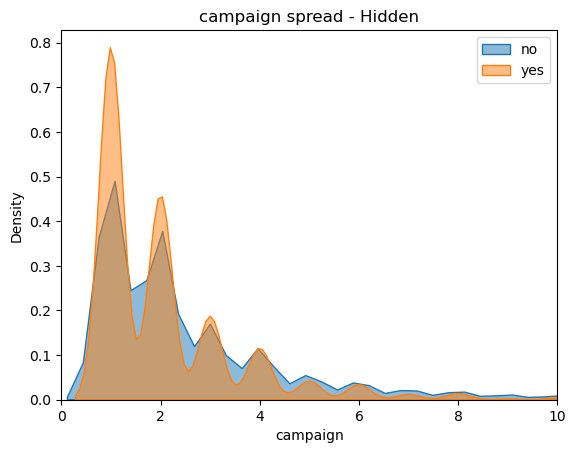

In [311]:
#To better visualize duration spread
feature = 'campaign'
sns.kdeplot(X_hidden[y_hidden == 0][feature],bw_adjust=0.5, fill=True, alpha=0.5,  label='no')
sns.kdeplot(X_hidden[y_hidden == 1][feature],bw_adjust=0.5, fill=True, alpha=0.5, label='yes')
plt.title('campaign spread - Hidden')
plt.legend()
plt.xlim(0,10) 
plt.savefig('PA3\\final\\feature_importance_campaign.png', dpi=300, bbox_inches='tight')
plt.show()

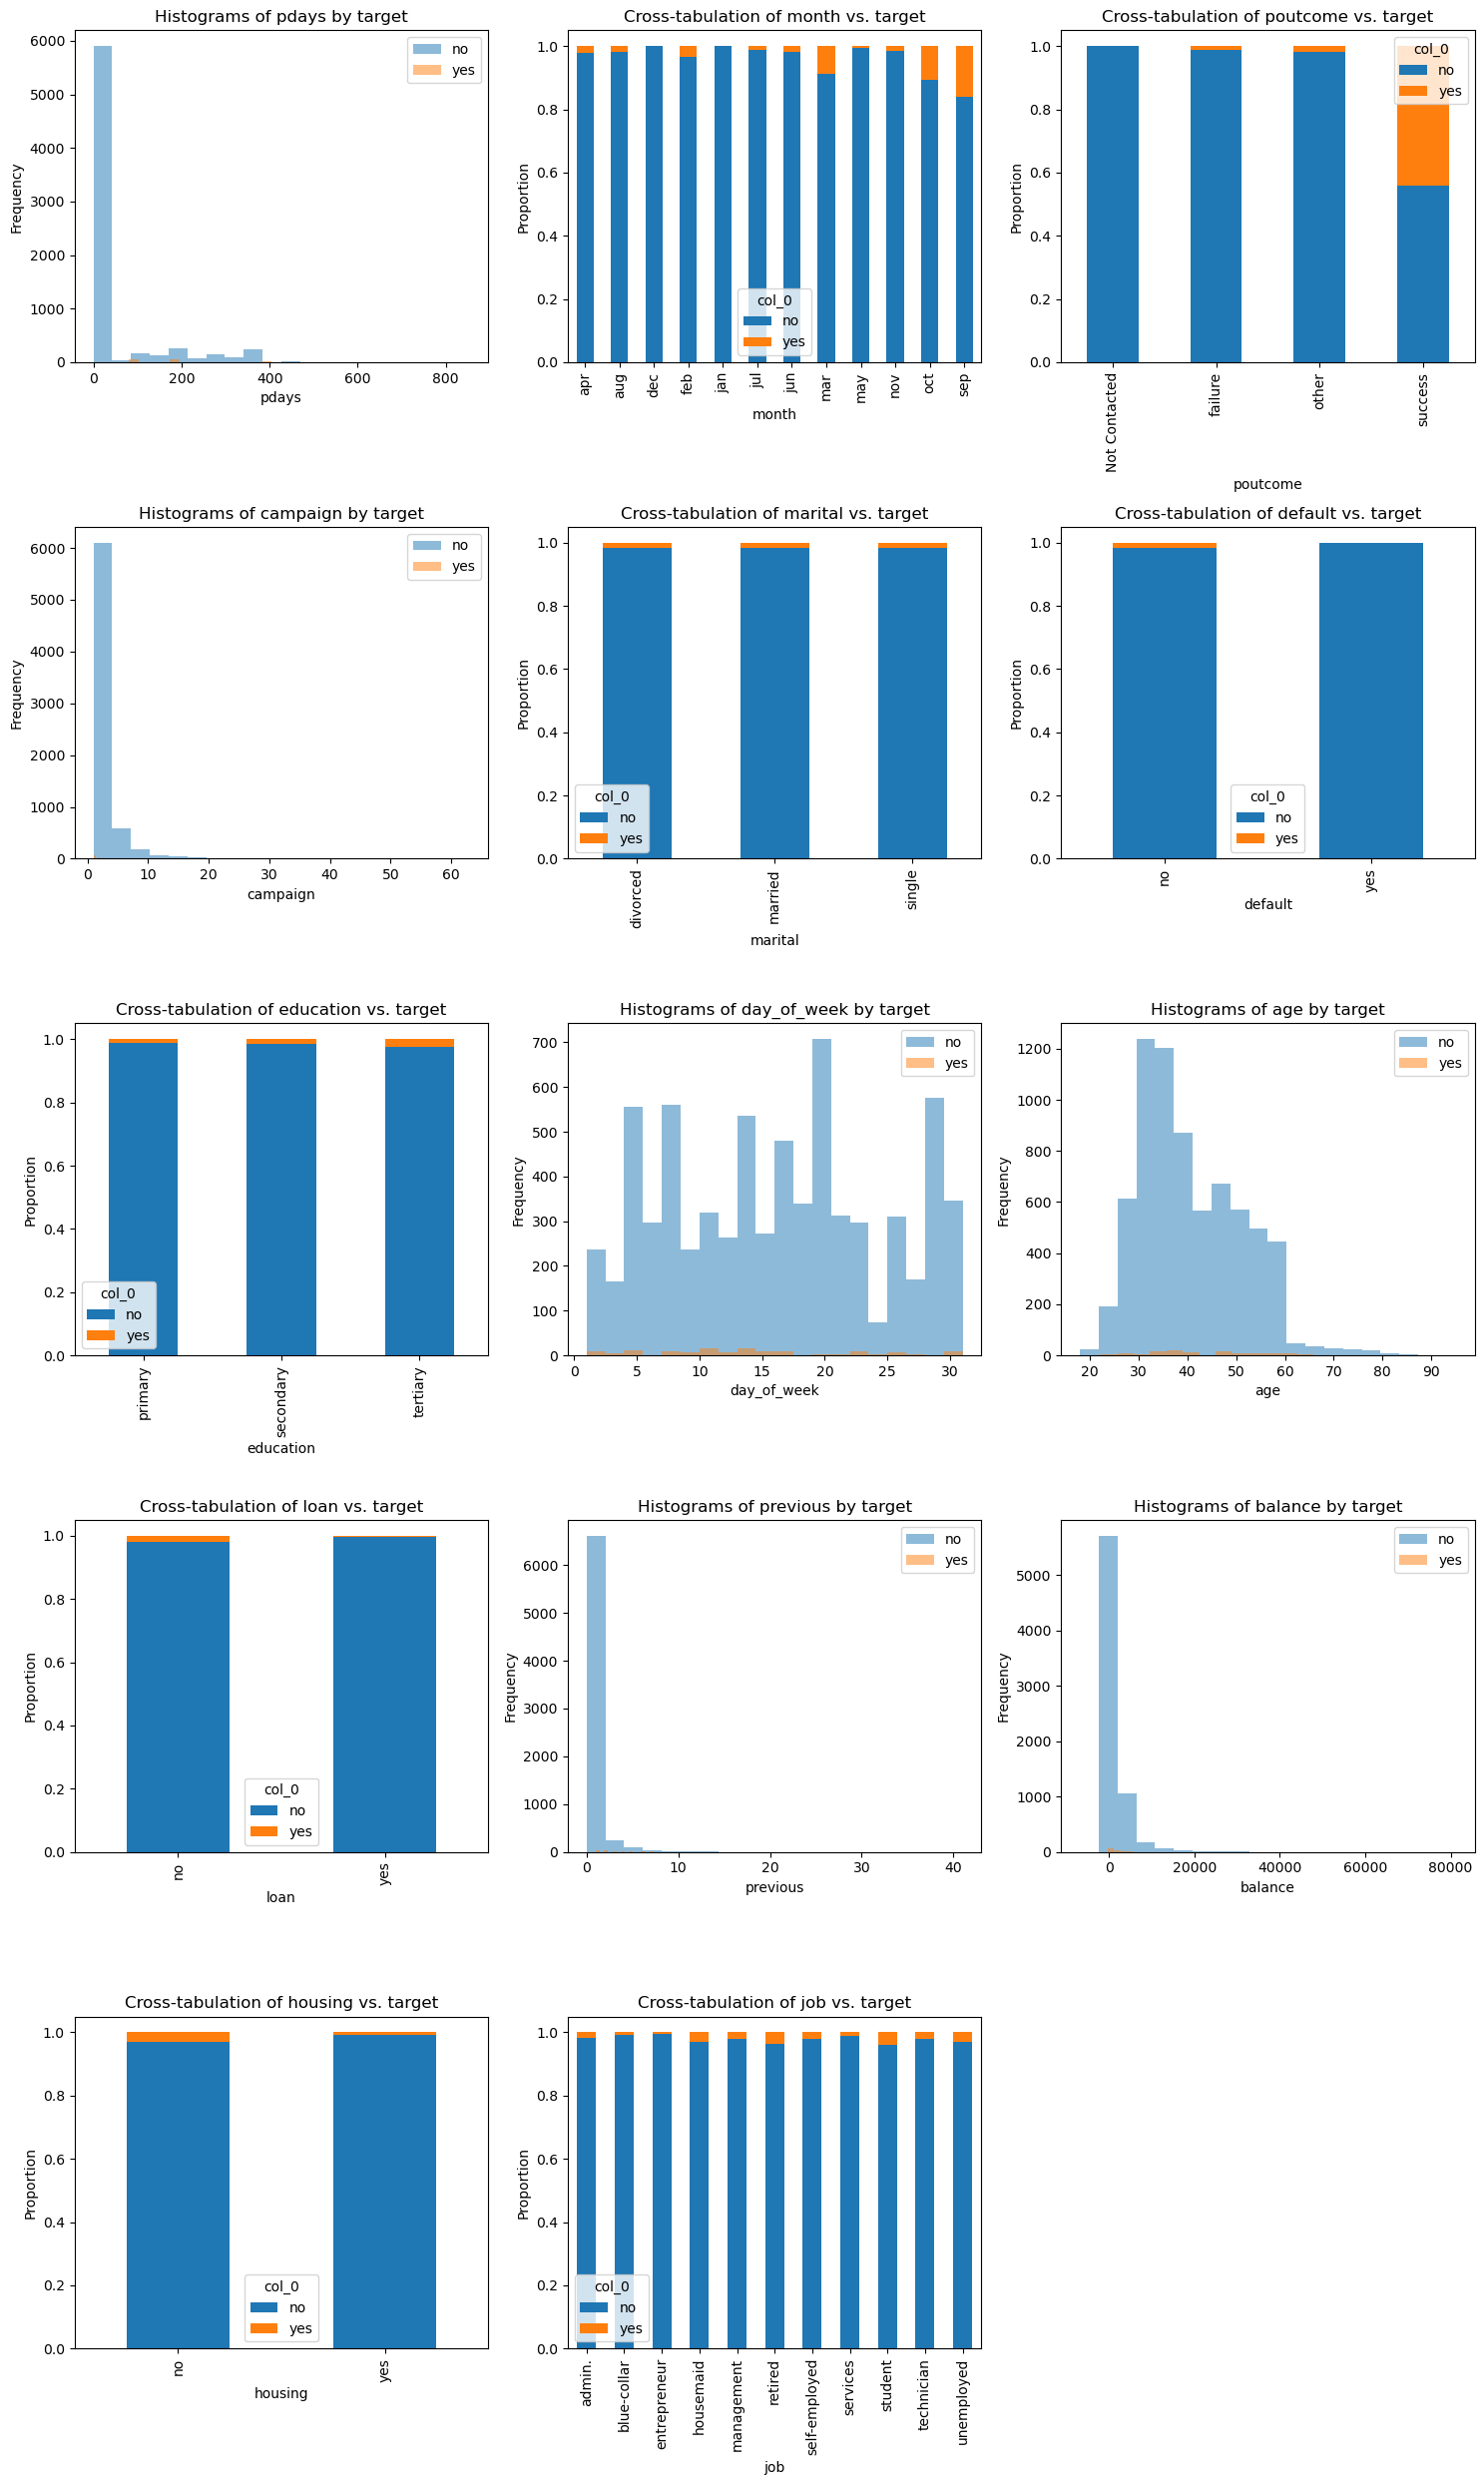

In [321]:
#Do the same for predicted dataset

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5 * num_rows))
axes = axes.flatten()
y_strings = np.where(predict_with_threshold(selected_model,X_hidden,0.3) == 1, 'yes', 'no')
# Loop through features and create plots
for i, feature in enumerate(features_sorted):
    if feature in categorical_features:
        # Categorical feature: Create cross-tabulation plot
        cross_tab = pd.crosstab(X_hidden[feature], y_strings, normalize='index')
        cross_tab.plot(kind='bar', stacked=True, ax=axes[i])
        axes[i].set_title(f"Cross-tabulation of {feature} vs. target")
        axes[i].set_ylabel("Proportion")

    elif feature in numerical_features:
        # Numerical feature: Create cross-histograms with buckets
        axes[i].hist(X_hidden[y_strings == 'no'][feature], alpha=0.5, bins=20,  label='no')
        axes[i].hist(X_hidden[y_strings == 'yes'][feature], alpha=0.5, bins=20, label='yes')
        axes[i].set_title(f"Histograms of {feature} by target")
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel("Frequency")
        axes[i].legend()

# Remove any unused subplots
for i in range(len(features_sorted), len(axes)):
    fig.delaxes(axes[i])


plt.tight_layout()
plt.savefig('PA3\\final\\feature_importance_spread_hidden_predicted.png', dpi=300, bbox_inches='tight')
plt.show()

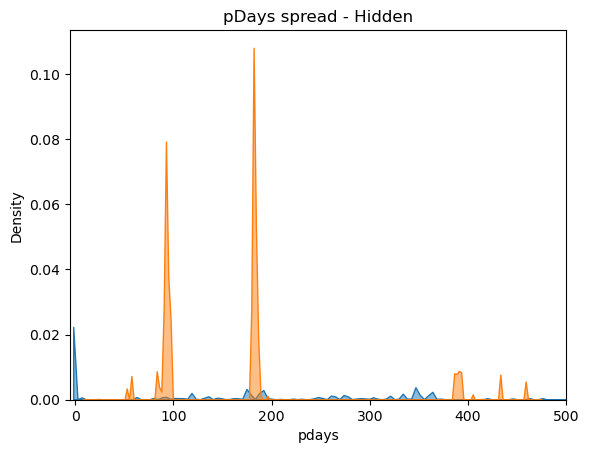

In [326]:
#To better visualize pdays spread for predicted dataset
feature = 'pdays'
sns.kdeplot(X_hidden[y_strings == 'no'][feature],bw_adjust=0.01, fill=True, alpha=0.5,  label='no')
sns.kdeplot(X_hidden[y_strings == 'yes'][feature],bw_adjust=0.01, fill=True, alpha=0.5, label='yes')

plt.title('pDays spread - Hidden')
plt.xlim(-5,500) 
plt.savefig('PA3\\final\\feature_importance_pdays_predicted.png', dpi=300, bbox_inches='tight')
plt.show()

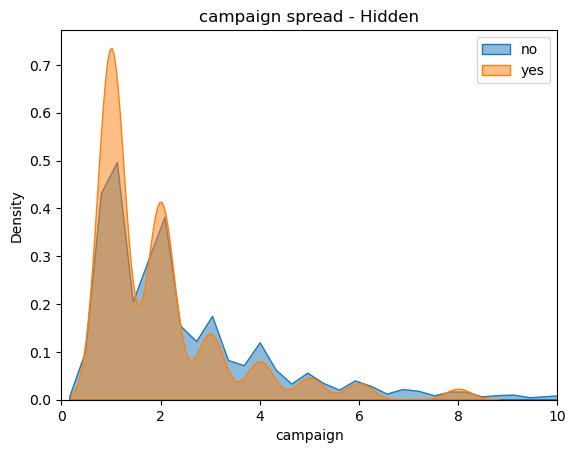

In [325]:
#To better visualize duration spread for predicted dataset
feature = 'campaign'
sns.kdeplot(X_hidden[y_strings == 'no'][feature],bw_adjust=0.5, fill=True, alpha=0.5,  label='no')
sns.kdeplot(X_hidden[y_strings == 'yes'][feature],bw_adjust=0.5, fill=True, alpha=0.5, label='yes')
plt.title('campaign spread - Hidden')
plt.legend()
plt.xlim(0,10) 
plt.savefig('PA3\\final\\feature_importance_campaign_predicted.png', dpi=300, bbox_inches='tight')
plt.show()

# Productionize This

To deploy, the following will need to be done
1. Save model for future use into a binary (using joblib)
2. Load the model from the saved file
3. Create a method to use the saved model to generate predictions for a new data record
4. Feed new data and use the prediction

Download Model

In [327]:
import joblib
joblib.dump(selected_model, 'bank_deposit_predictor.model')

['bank_deposit_predictor.model']

Import the model back

In [328]:
loaded_model = joblib.load('bank_deposit_predictor.model')
loaded_model

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder=RobustScaler(),
                                   transformers=[('ordinalencoder-1',
                                                  OrdinalEncoder(categories=[['primary',
                                                                              'secondary',
                                                                              'tertiary']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['education']),
                                                 ('ordinalencoder-2',
                                                  OrdinalEncoder(categories=[['jan',
                                                                              'feb',
                                                                              'mar',
                                                                              'apr',
                                                                              'may',
                                                                              'jun',
                                                                              'jul',
                                                                              'aug',
                                                                              'sep',
                                                                              'oct',
                                                                              'nov',
                                                                              'dec']]),
                                                  ['month']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'loan',
                                                   'poutcome'])])),
                ('classifier', SVC(C=1, gamma='auto'))])

Create the method for prediction

In [330]:
def predict_customer_signup(model, input_data):
    """
    Is it worth calling the customer? Will the customer sign up for the Deposit?

    Parameters:
    - model: Tuend SVC based model
    - input_data: DataFrame containing the input features for the new data

    Returns:
    - predicted_values: Yes/No
    """
    #threshold odentified from tuning!
    threshold = 0.3 #selected_threshold

    # Get decision function scores
    decision_scores = model.decision_function(input_data)
    print(decision_scores)

    # Apply the threshold
    predicted_labels = np.where(decision_scores >= threshold, 'yes', 'no')

    return predicted_labels


In [343]:
#This could be read in from a CSV or even used via an API as described lated on
new_customer_data = {
'age': [20,40,50],
'job': ['student','retired','admin.'],
'marital': ['single','married','married'],
'education': ['secondary','tertiary','secondary'],
'default': ['no','no','no'],
'balance': [10,10,2000],
'housing': ['yes','no','yes'],
'loan': ['no','no','no'],
'day_of_week': [30,30,30],
'month': ['jan','mar','sep'],
'campaign': [10,50,1],
'pdays': [10,30,180],
'previous': [10,0,1],
'poutcome' : ['other','failure','success']    
}

new_customer_df = pd.DataFrame(new_customer_data)
new_customer_df

age      job  marital  education default  balance housing loan  \
0   20  student   single  secondary      no       10     yes   no   
1   40  retired  married   tertiary      no       10      no   no   
2   50   admin.  married  secondary      no     2000     yes   no   

   day_of_week month  campaign  pdays  previous poutcome  
0           30   jan        10     10        10    other  
1           30   mar        50     30         0  failure  
2           30   sep         1    180         1  success

In [344]:
prediction = predict_customer_signup(loaded_model, new_customer_df)
new_customer_df['prediction'] = prediction
new_customer_df

[-0.73905509 -0.62999798  0.44715368]


age      job  marital  education default  balance housing loan  \
0   20  student   single  secondary      no       10     yes   no   
1   40  retired  married   tertiary      no       10      no   no   
2   50   admin.  married  secondary      no     2000     yes   no   

   day_of_week month  campaign  pdays  previous poutcome prediction  
0           30   jan        10     10        10    other         no  
1           30   mar        50     30         0  failure         no  
2           30   sep         1    180         1  success        yes

## Convert to API

In [345]:
from fastapi import FastAPI
from pydantic import BaseModel #Help define the format
import pandas as pd
import joblib
import numpy as np

class customer(BaseModel):
    age: int
    job: str
    marital: str
    education: str
    default: str
    balance: int
    housing: str
    loan: str
    day_of_week: int
    month: str
    campaign: int
    pdays: int
    previous: int
    poutcome: str
    

app = FastAPI()

@app.post('/predict')
def predict_dep(customer: customer):
    #print customer to the console
    print(customer)
    loaded_model = joblib.load('<Path>\bank_deposit_predictor.model')
    threshold = 0.5
    customer_dict = customer.dict()
    input_data = pd.DataFrame([customer_dict])
    decision_scores = loaded_model.decision_function(input_data)
    print(decision_scores)
    return str(np.where(decision_scores >= threshold, 'yes', 'no')[0])

### Test Input

- For "NO" \
{
  "age": 20,
  "job": "admin.",
  "marital": "single",
  "education": "primary",
  "default": "no",
  "balance": 500,
  "housing": "no",
  "loan": "yes",
  "day_of_week": 2,
  "month": "jan",
  "campaign": 1,
  "pdays": 4,
  "previous": 100
  "poutcome" :"other"
}

- For "YES" \
{
  "age": 50,
  "job": "admin.",
  "marital": "married",
  "education": "secondary",
  "default": "no",
  "balance": 2000,
  "housing": "yes",
  "loan": "no",
  "day_of_week": 30,
  "month": "sep",
  "campaign": 1,
  "pdays": 180,
  "previous": 1
  "poutcome" :"success"
}